In [1]:
# Import Statements


%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import importlib


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
color = sns.color_palette()


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
num_classes=5


#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

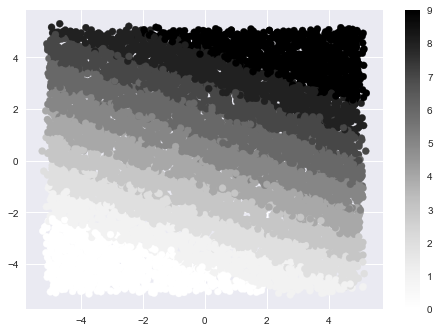

In [2]:
num_classes = 10
dim = 2

def generateLinearData(num_samples = 10000, num_classes = num_classes, dim = dim, bound = 5, sigma_noise = .1,rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
        
    fvec = np.random.rand(dim, num_samples)*bound*2-bound
    label = np.dot((np.random.rand(1,dim)*bound*2-bound).reshape(1,-1),fvec)

    sorted_idx = np.argsort(label)
    bin_size = label.shape[1]/num_classes

    for k in range(0, num_classes):
        label[0, sorted_idx[0, np.floor(k*bin_size).astype(int):np.floor((k+1)*bin_size).astype(int)]] = rand_classes[k]

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateLinearData(rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label)
plt.colorbar()


(1, 10000)


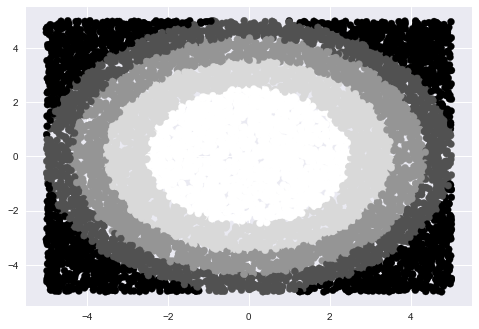

In [3]:
def generateCircularData(num_samples = 10000, num_classes = num_classes, dim = dim,
                         bound = 5, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
        
    fvec = np.random.rand(dim, num_samples)*bound*2-bound
    
    fvec_l = np.sum(fvec**2, axis = 0).reshape(1,-1)
    print(fvec_l.shape)
    label = fvec_l

    sorted_idx = np.argsort(label)
    bin_size = label.shape[1]/num_classes

    for k in range(0, num_classes):
        label[0, sorted_idx[0, np.floor(k*bin_size).astype(int):np.floor((k+1)*bin_size).astype(int)]] = rand_classes[k]

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateCircularData(num_classes =5, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Greys'))


(1, 10000)


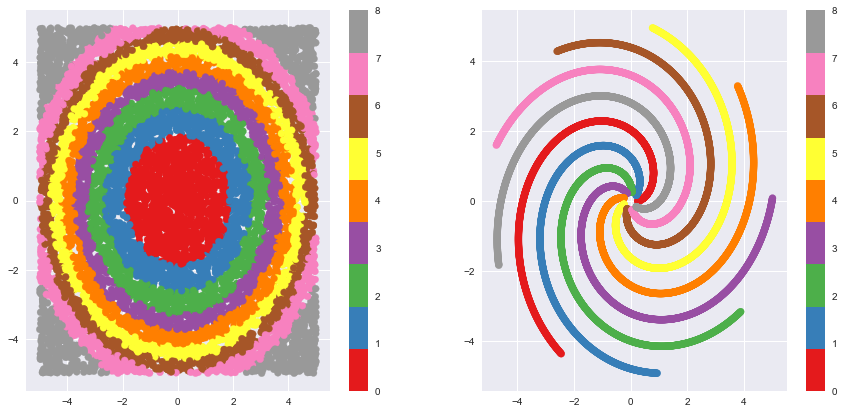

In [4]:
def generateSpiralData(num_samples = 10000, num_classes = num_classes, dim = dim,
                         bound = 5, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
    
    #rand_classes = [1, 1.5, -1, -1.5]
    sample_per_class = int(num_samples/num_classes)
    num_samples = sample_per_class*num_classes
    fvec = np.zeros((dim, sample_per_class*num_classes))
    label = np.zeros((1, sample_per_class*num_classes))
    
    t = np.linspace(0, 10, sample_per_class)
    x = t * np.cos(t)
    y = t * np.sin(t)
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)

    cons = .7
    for k in range(0, num_classes):
        r = np.linspace(0.05, 1, sample_per_class)
        t = np.linspace(k*cons, (k+6)*cons, sample_per_class)
        x = np.cos(t)
        y = np.sin(t)
        x = x.reshape(1, -1)
        y = y.reshape(1, -1)
        label[0, k*sample_per_class:(k+1)*sample_per_class] = rand_classes[k]
        fvec[0, k*sample_per_class:(k+1)*sample_per_class] = bound * x * r
        fvec[1, k*sample_per_class:(k+1)*sample_per_class] = bound * y * r

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

plt.figure(figsize=(15,7))
plt.subplot(121)
fvec, label = generateCircularData(num_classes =9, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Set1'))
plt.colorbar()
plt.subplot(122)
fvec, label = generateSpiralData(num_classes = 9, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Set1'))
plt.colorbar()
plt.savefig('circular_vs_spiral.tiff')

# Train an MLP network

In [5]:
def make_coeff(n, metric, lmbda = 1):
    if metric is 'ccr':
        return [1]
    elif metric is 'ccr1':
        return [1, 1, 1]
    elif metric is 'mae':
        coeff = np.arange(1,n)/(n-1)
    elif metric is 'mse':
        coeff = np.zeros(n-1)
        coeff[0] = 2*n-3
        for k in range(1, n-1):
            coeff[k] = coeff[k-1] + 2*n - (2*(k+1)+1)
        coeff = coeff /((n-1)**2)
    else:
        print('Undefined Metric: ' + metric)
    coeff = np.concatenate((coeff, coeff[::-1][1:]), axis=0)
    coeff = coeff * lmbda
    coeff[n-2] = 1
    return coeff

In [35]:
data_type = 'circular'
num_samples = 10000
num_classes = 9
nclasses = num_classes
dim = 2

sigma_noise = 0.1
optimizer='sgd' #Optimizer function
iter_loc=10 #Number of the first column in the excel file for writing the results.
lr=.5 #Initial learning rate
momentum=0.9
weight_decay=0.0005
batch_size = 64
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
hidden_sizes = [4]
dropouts = [1]
rand_label = False

metric = 'ccr1'
coeff_lmbda =  1
multi_coeff = make_coeff(nclasses, metric, coeff_lmbda)
KL = False #KL divergence for porbability measure


'''Multipliers for loss functions'''
single_loss=0.
multi_loss=1.

comment=' ' #Additional comments if any



In [36]:


if data_type == 'circular':
    fvec, label = generateCircularData(num_samples = num_samples, 
                                       num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
elif data_type == 'linear':
    fvec, label = generateLinearData(num_samples = num_samples, 
                                     num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
elif data_type == 'spiral':
    fvec, label = generateSpiralData(num_samples = num_samples, 
                                     num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
else:
    print('!!!! WRONG DATA TYPE')


rand_idx = np.random.permutation(len(label))
fvec_norm = (fvec)/5
mid_point = int(len(label)/2)#100*num_classes
fvec_test = fvec_norm[rand_idx[:mid_point],:]
fvec_train = fvec_norm[rand_idx[mid_point:],:]

label_test = label[rand_idx[:mid_point]]
label_train = label[rand_idx[mid_point:]]
print(np.max(fvec_train))
print(np.min(fvec_train))

torch.from_numpy(label_train).type(torch.LongTensor)
dsets={'train': torch.utils.data.TensorDataset(torch.from_numpy(fvec_train).type(torch.FloatTensor),
                                               torch.from_numpy(label_train).type(torch.LongTensor)),
       'val': torch.utils.data.TensorDataset(torch.from_numpy(fvec_test).type(torch.FloatTensor),
                                             torch.from_numpy(label_test).type(torch.LongTensor))}

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=True,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}


dset_sizes={'train':len(dsets['train']),'val':len(dsets['val'])}
use_gpu = torch.cuda.is_available()

print(dset_sizes)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

inputs, classes = next(iter(dset_loaders['train']))
print(inputs.shape)


(1, 10000)
1.03329957463
-1.03038243591
{'train': 5000, 'val': 5000}
!!!!! NO CUDA GPUS DETECTED
torch.Size([64, 2])


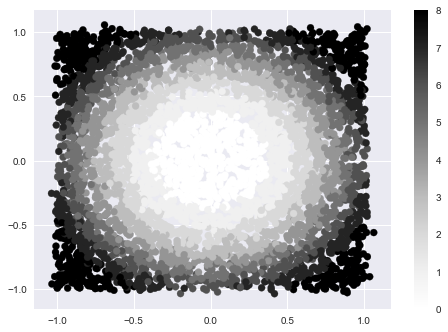

In [40]:
plt.scatter(fvec_test[:, 0], fvec_test[:, 1], c=label_test)
plt.colorbar()

In [8]:
def writeLog(logname):
    '''
    Creates a text file named Network_properties.txt inside runs/'logname'
    '''
    f=open('runs_regression/'+logname+'/Network_properties.txt','w')
    f.write('Feature Length: '+str(dim)+'\n')
    f.write('Number of classes: '+str(num_classes)+'\n')
    f.write('Data type: '+data_type+'\n')
    f.write('Random Noise: '+str(sigma_noise)+'\n')
    
    f.write('Hidden sizes: '+ str(hidden_sizes)+'\n')
    f.write('Dropouts: '+str(dropouts)+'\n')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Number of samples: '+str(num_samples)+'\n')
    
    f.write('Optimizer: ' + optimizer + '\n')
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.close()

In [9]:
import openpyxl
import time

def writeLog_xlsx(logname='logs_regression.xlsx',iter_loc=10):
    '''
    Adds a line to logs.xlsx with the network properties and outcomes.
    :param iter_loc: First column to record the outcomes.
    '''
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    if metric:
        m_coeff = make_coeff(nclasses, metric, coeff_lmbda)
    else:
        m_coeff = multi_coeff
    specs=(datetime.now().strftime('%B%d  %H:%M:%S'),data_type,str(hidden_sizes),str(dim),str(num_classes),
           crt, str(lr), str(m_coeff), str(KL))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    book.save(logname)

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropouts, num_classes):
        super(Net, self).__init__()
        self.numHidden=len(hidden_sizes)
        setattr(self, 'fc0', nn.Linear(input_size, hidden_sizes[0]))
        setattr(self, 'relu0', nn.ReLU())
        setattr(self, 'drop0', nn.Dropout(p=dropouts[0]))
        for k in range(len(hidden_sizes)-1):
            setattr(self, 'fc'+str(k+1), nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            setattr(self, 'relu'+str(k+1), nn.ReLU())
            setattr(self, 'drop'+str(k+1), nn.Dropout(p=dropouts[k+1]))
        setattr(self, 'fc'+str(len(hidden_sizes)), nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):
        out=self.fc0(x)
        out = self.relu0(out)
        #out = self.drop0(out)
        for k in range(self.numHidden-1):
            fc = getattr(self,'fc'+str(k+1))
            relu = getattr(self,'relu'+str(k+1))
            drop = getattr(self,'drop'+str(k+1))
            out = fc(out)
            out = relu(out)
            out = drop(out)
        fc = getattr(self,'fc'+str(self.numHidden))
        out = fc(out)
        return out
    
model=Net(2, [4, 4, 4],[.3, .3, 1], 2)
print(model)

Net (
  (fc0): Linear (2 -> 4)
  (relu0): ReLU ()
  (drop0): Dropout (p = 0.3)
  (fc1): Linear (4 -> 4)
  (relu1): ReLU ()
  (drop1): Dropout (p = 0.3)
  (fc2): Linear (4 -> 4)
  (relu2): ReLU ()
  (drop2): Dropout (p = 1)
  (fc3): Linear (4 -> 2)
)


In [11]:
def network_loader(comment=comment,
                    optimizer=optimizer,
                    iter_loc=iter_loc,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    nclasses=num_classes,
                    hidden_sizes = hidden_sizes,
                    dropouts = dropouts):
    
    '''Load the network from pytorch'''
    
    model_ft = Net(dim, hidden_sizes , dropouts, num_classes)

    if use_gpu:
        model_ft = model_ft.cuda()

    '''Define the optimizer function'''
    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft

In [12]:
def write_epochs(result_log, logname):
    print(len(result_log))

    wb_tr = openpyxl.Workbook()
    ws_tr = wb_tr.active
    wb_val = openpyxl.Workbook()
    ws_val = wb_val.active
    print(logname)

    label_arr_tr = np.zeros((100000,1))
    probs_arr_tr = np.zeros((100000, num_classes))
    label_arr_val = np.zeros((100000,1))
    probs_arr_val = np.zeros((100000, num_classes))

    prev_epoch = 0
    
    count_tr = count_val = 0
    for result in result_log:
        epoch = result[1]
        if not epoch == prev_epoch:
            label_arr_tr = label_arr_tr[:count_tr]
            probs_arr_tr = probs_arr_tr[:count_tr, :]
            label_arr_val = label_arr_val[:count_val]
            probs_arr_val = probs_arr_val[:count_val, :]
            ws_tr.append(['Epoch ' + str(prev_epoch)])
            ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
            ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_tr[1:,:].T.tolist():
                ws_tr.append(probs)
            #wb_tr.save('./runs_ord/'+logname + '/train.xlsx')
            ws_val.append(['Epoch ' + str(prev_epoch)])
            ws_val.append(label_arr_val[1:].reshape(-1).tolist())
            ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_val[1:,:].T.tolist():
                ws_val.append(probs)
    

            label_arr_tr = np.zeros((100000,1))
            probs_arr_tr = np.zeros((100000, num_classes))
            label_arr_val = np.zeros((100000,1))
            probs_arr_val = np.zeros((100000, num_classes)) 
            count_tr = count_val = 0
            prev_epoch = epoch

        label = np.asarray(result[2]).reshape(-1,1)
        scores = np.asarray(result[3])
        exp_scores = np.exp(scores - np.max(scores,axis=1).reshape(-1, 1)*np.ones(num_classes))
        probs = np.round(exp_scores/(np.sum(exp_scores,axis=1).reshape(-1, 1)*np.ones(num_classes)), decimals=2)
        if result[0] == 'train':
            label_arr_tr[count_tr:count_tr + len(label)]  = label
            probs_arr_tr[count_tr:count_tr + len(label), :] = probs
            count_tr += len(label)
        elif result[0] == 'val':
            label_arr_val[count_val:count_val + len(label)]  = label
            probs_arr_val[count_val:count_val + len(label), :] = probs
            count_val += len(label)


    
    label_arr_tr = label_arr_tr[:count_tr]
    probs_arr_tr = probs_arr_tr[:count_tr, :]
    label_arr_val = label_arr_val[:count_val]
    probs_arr_val = probs_arr_val[:count_val, :]
            
    ws_tr.append(['Epoch ' + str(epoch)])
    ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
    ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_tr[1:,:].T.tolist():
        ws_tr.append(probs)
    #wb_tr.save('./runs_ord/'+logname + '/train.xlsx')
    ws_val.append(['Epoch ' + str(epoch)])
    ws_val.append(label_arr_val[1:].reshape(-1).tolist())
    ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_val[1:,:].T.tolist():
        ws_val.append(probs)
    wb_val.save('./runs_regression/'+logname + '/val.xlsx')
    label_arr_tr = np.zeros((1,1))
    probs_arr_tr = np.zeros((1, num_classes))
    label_arr_val = np.zeros((1,1))
    probs_arr_val = np.zeros((1, num_classes))
    prev_epoch = epoch
    print('Finito')
    
    del label_arr_tr, probs_arr_tr, label_arr_val, probs_arr_val


In [13]:
importlib.reload(ft)
    
def run_network():
    '''
    Cretaes the log files and starts the training
    '''
    model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            nclasses=num_classes)
    
    
    '''Name of the trial'''
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    logname='Ordinal_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs_regression/'+logname) #For tensorboard
    writeLog(logname)
    writeLog_xlsx()
    
    '''Start trianing'''
    if metric:
        m_coeff = make_coeff(nclasses, metric, coeff_lmbda)
    else:
        m_coeff = multi_coeff
    best_model, last_model, result_log = ft.train_model(model_ft,optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,use_gpu=use_gpu,num_epochs=50,batch_size=batch_size,num_log=250,
                            multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr,mse_loss=False,
                            iter_loc=iter_loc,cross_loss=single_loss,multi_loss=multi_loss,numOut=num_classes,
                            logname='logs_regression.xlsx',
                            multi_coeff = m_coeff, single_coeff = m_coeff, KL = KL)
    
    '''Save the models'''
    torch.save(best_model,'./saved_models/ord/'+logname+'_best')
    torch.save(last_model,'./saved_models/ord/'+logname+'_last')
    
    '''print('Writing results')
    write_epochs(result_log, logname)
    print('Wrote results')'''
    '''Free up the memory'''
    del model_ft, result_log
    
    return last_model


In [17]:
end_to_end = True
optimizer='adam' #Optimizer function
lr=0.1 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay

hidden_sizes = [4, 4, 4]#8, 16, 8, 4, 4]
dropouts = []#.5, .5, .5]
single_loss=1.0
multi_loss =0.0

KL = True
metric = None

'''for lmbda_mae in [.1*k for k in range(11)]:
    multi_coeff = lmbda_mae * np.asarray(make_coeff(nclasses, 'ccr1', coeff_lmbda))
    multi_coeff[int((len(multi_coeff)-1)/2)] = 1.
    for k in range(10):
        run_network()'''
        
for lmbda_mae in [.1*k for k in range(5,11)]:
    
    multi_coeff = lmbda_mae * np.asarray(make_coeff(nclasses, 'mae', coeff_lmbda))
    multi_coeff[int((len(multi_coeff)-1)/2)] = 1.
    for k in range(10):
        run_network()
    
'''KL = True
metric = 'ccr'
for k in range(10):
    run_network()
    
metric = 'ccr1'
for k in range(10):
    run_network()
    
metric = 'mae'
for k in range(10):
    run_network()
    
metric = 'mse'
for k in range(10):
    run_network()'''
    


Multi_coef is [ 0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375  1.      0.4375
  0.375   0.3125  0.25    0.1875  0.125   0.0625]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0003 Acc: 0.1508 CIR-1: 0.4266 RMSE 2.5656
val Loss: 0.0003 Acc: 0.1964 CIR-1: 0.4866 RMSE 2.3063

Epoch 1/49
----------
train Loss: 0.0002 Acc: 0.2780 CIR-1: 0.6264 RMSE 1.9013
val Loss: 0.0002 Acc: 0.4642 CIR-1: 0.8772 RMSE 0.9717

Epoch 2/49
----------
train Loss: 0.0002 Acc: 0.3778 CIR-1: 0.7706 RMSE 1.3212
val Loss: 0.0002 Acc: 0.3570 CIR-1: 0.8138 RMSE 1.1825

Epoch 3/49
----------
train Loss: 0.0002 Acc: 0.3720 CIR-1: 0.7636 RMSE 1.3345
val Loss: 0.0002 Acc: 0.3484 CIR-1: 0.7344 RMSE 1.3324

Epoch 4/49
----------
train Loss: 0.0002 Acc: 0.3940 CIR-1: 0.7918 RMSE 1.2508
val Loss: 0.0002 Acc: 0.4296 CIR-1: 0.8262 RMSE 1.1815

Epoch 5/49
----------
train Loss: 0.0002 Acc: 0.4062 CIR-1: 0.8232 RMSE 1.1627
val Loss: 0.0002 Acc: 0.3980 CIR-1: 0.7812 RMSE 1.3534

Epoch 6/49
----------
train Loss: 0.

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Multi_coef is [ 0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375  1.      0.4375
  0.375   0.3125  0.25    0.1875  0.125   0.0625]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0003 Acc: 0.1780 CIR-1: 0.4742 RMSE 2.5569
val Loss: 0.0002 Acc: 0.2964 CIR-1: 0.5928 RMSE 1.9551

Epoch 1/49
----------
train Loss: 0.0002 Acc: 0.3362 CIR-1: 0.7286 RMSE 1.4740
val Loss: 0.0002 Acc: 0.3632 CIR-1: 0.7744 RMSE 1.2543

Epoch 2/49
----------
train Loss: 0.0002 Acc: 0.3634 CIR-1: 0.7594 RMSE 1.3211
val Loss: 0.0002 Acc: 0.4016 CIR-1: 0.7936 RMSE 1.2208

Epoch 3/49
----------
train Loss: 0.0002 Acc: 0.3746 CIR-1: 0.7710 RMSE 1.2944
val Loss: 0.0002 Acc: 0.3188 CIR-1: 0.7192 RMSE 1.4412

Epoch 4/49
----------
train Loss: 0.0002 Acc: 0.3594 CIR-1: 0.7626 RMSE 1.3136
val Loss: 0.0002 Acc: 0.2796 CIR-1: 0.6854 RMSE 1.6317

Epoch 5/49
----------
train Loss: 0.0002 Acc: 0.3636 CIR-1: 0.7630 RMSE 1.3154
val Loss: 0.0002 Acc: 0.3686 CIR-1: 0.7012 RMSE 1.3767

Epoch 6/49
----------
train Loss: 0.


Epoch 7/49
----------
train Loss: 0.0002 Acc: 0.4254 CIR-1: 0.8320 RMSE 1.1238
val Loss: 0.0002 Acc: 0.4290 CIR-1: 0.8486 RMSE 1.2020

Epoch 8/49
----------
train Loss: 0.0002 Acc: 0.3940 CIR-1: 0.8168 RMSE 1.1860
val Loss: 0.0002 Acc: 0.3210 CIR-1: 0.7370 RMSE 1.3376

Epoch 9/49
----------
train Loss: 0.0002 Acc: 0.4168 CIR-1: 0.8270 RMSE 1.1470
val Loss: 0.0002 Acc: 0.4830 CIR-1: 0.8424 RMSE 1.0520

Epoch 10/49
----------
LR is set to 0.010000000000000002
train Loss: 0.0002 Acc: 0.5048 CIR-1: 0.9128 RMSE 0.8898
val Loss: 0.0002 Acc: 0.5278 CIR-1: 0.9330 RMSE 0.8421

Epoch 11/49
----------
train Loss: 0.0002 Acc: 0.5052 CIR-1: 0.9274 RMSE 0.8512
val Loss: 0.0002 Acc: 0.5468 CIR-1: 0.9452 RMSE 0.8004

Epoch 12/49
----------
train Loss: 0.0002 Acc: 0.5178 CIR-1: 0.9200 RMSE 0.8661
val Loss: 0.0002 Acc: 0.4976 CIR-1: 0.9384 RMSE 0.8433

Epoch 13/49
----------
train Loss: 0.0002 Acc: 0.4996 CIR-1: 0.9226 RMSE 0.8669
val Loss: 0.0002 Acc: 0.5118 CIR-1: 0.9412 RMSE 0.8158

Epoch 14/49
----

val Loss: 0.0002 Acc: 0.5180 CIR-1: 0.9358 RMSE 0.8340

Epoch 15/49
----------
train Loss: 0.0002 Acc: 0.5112 CIR-1: 0.9108 RMSE 0.8834
val Loss: 0.0002 Acc: 0.4826 CIR-1: 0.8956 RMSE 0.9357

Epoch 16/49
----------
train Loss: 0.0002 Acc: 0.5136 CIR-1: 0.9194 RMSE 0.8638
val Loss: 0.0002 Acc: 0.5046 CIR-1: 0.9184 RMSE 0.8850

Epoch 17/49
----------
train Loss: 0.0002 Acc: 0.4816 CIR-1: 0.9102 RMSE 0.9087
val Loss: 0.0002 Acc: 0.5060 CIR-1: 0.9394 RMSE 0.8233

Epoch 18/49
----------
train Loss: 0.0002 Acc: 0.5006 CIR-1: 0.9254 RMSE 0.8627
val Loss: 0.0002 Acc: 0.4834 CIR-1: 0.9084 RMSE 0.9151

Epoch 19/49
----------
train Loss: 0.0002 Acc: 0.5076 CIR-1: 0.9208 RMSE 0.8643
val Loss: 0.0002 Acc: 0.4580 CIR-1: 0.9010 RMSE 0.9311

Epoch 20/49
----------
LR is set to 0.0010000000000000002
train Loss: 0.0002 Acc: 0.4930 CIR-1: 0.9178 RMSE 0.8784
val Loss: 0.0002 Acc: 0.5042 CIR-1: 0.9444 RMSE 0.8262

Epoch 21/49
----------
train Loss: 0.0002 Acc: 0.5252 CIR-1: 0.9460 RMSE 0.8055
val Loss: 0.0

train Loss: 0.0002 Acc: 0.5210 CIR-1: 0.9482 RMSE 0.8027
val Loss: 0.0002 Acc: 0.4996 CIR-1: 0.9440 RMSE 0.8285

Epoch 23/49
----------
train Loss: 0.0002 Acc: 0.5132 CIR-1: 0.9396 RMSE 0.8258
val Loss: 0.0002 Acc: 0.5146 CIR-1: 0.9444 RMSE 0.8162

Epoch 24/49
----------
train Loss: 0.0002 Acc: 0.5108 CIR-1: 0.9502 RMSE 0.8041
val Loss: 0.0002 Acc: 0.5120 CIR-1: 0.9510 RMSE 0.8056

Epoch 25/49
----------
train Loss: 0.0002 Acc: 0.5162 CIR-1: 0.9434 RMSE 0.8165
val Loss: 0.0002 Acc: 0.5218 CIR-1: 0.9514 RMSE 0.7994

Epoch 26/49
----------
train Loss: 0.0002 Acc: 0.5326 CIR-1: 0.9508 RMSE 0.7906
val Loss: 0.0002 Acc: 0.5138 CIR-1: 0.9512 RMSE 0.8029

Epoch 27/49
----------
train Loss: 0.0002 Acc: 0.5130 CIR-1: 0.9480 RMSE 0.8075
val Loss: 0.0002 Acc: 0.5086 CIR-1: 0.9536 RMSE 0.8022

Epoch 28/49
----------
train Loss: 0.0002 Acc: 0.5132 CIR-1: 0.9414 RMSE 0.8213
val Loss: 0.0002 Acc: 0.5168 CIR-1: 0.9528 RMSE 0.8049

Epoch 29/49
----------
train Loss: 0.0002 Acc: 0.5430 CIR-1: 0.9466 RMS


Epoch 30/49
----------
LR is set to 0.00010000000000000003
train Loss: 0.0002 Acc: 0.5220 CIR-1: 0.9538 RMSE 0.7916
val Loss: 0.0002 Acc: 0.5148 CIR-1: 0.9564 RMSE 0.7937

Epoch 31/49
----------
train Loss: 0.0002 Acc: 0.5226 CIR-1: 0.9550 RMSE 0.7889
val Loss: 0.0002 Acc: 0.5162 CIR-1: 0.9564 RMSE 0.7928

Epoch 32/49
----------
train Loss: 0.0002 Acc: 0.5240 CIR-1: 0.9536 RMSE 0.7901
val Loss: 0.0002 Acc: 0.5122 CIR-1: 0.9552 RMSE 0.7970

Epoch 33/49
----------
train Loss: 0.0002 Acc: 0.5234 CIR-1: 0.9524 RMSE 0.7927
val Loss: 0.0002 Acc: 0.5106 CIR-1: 0.9548 RMSE 0.7994

Epoch 34/49
----------
train Loss: 0.0002 Acc: 0.5238 CIR-1: 0.9524 RMSE 0.7925
val Loss: 0.0002 Acc: 0.5092 CIR-1: 0.9542 RMSE 0.8007

Epoch 35/49
----------
train Loss: 0.0002 Acc: 0.5206 CIR-1: 0.9508 RMSE 0.7975
val Loss: 0.0002 Acc: 0.5098 CIR-1: 0.9532 RMSE 0.8029

Epoch 36/49
----------
train Loss: 0.0002 Acc: 0.5268 CIR-1: 0.9514 RMSE 0.7925
val Loss: 0.0002 Acc: 0.5116 CIR-1: 0.9534 RMSE 0.8007

Epoch 37/49

val Loss: 0.0002 Acc: 0.5174 CIR-1: 0.9536 RMSE 0.7961

Epoch 38/49
----------
train Loss: 0.0002 Acc: 0.5220 CIR-1: 0.9512 RMSE 0.7946
val Loss: 0.0002 Acc: 0.5138 CIR-1: 0.9534 RMSE 0.7987

Epoch 39/49
----------
train Loss: 0.0002 Acc: 0.5228 CIR-1: 0.9538 RMSE 0.7892
val Loss: 0.0002 Acc: 0.5160 CIR-1: 0.9554 RMSE 0.7930

Epoch 40/49
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0002 Acc: 0.5238 CIR-1: 0.9544 RMSE 0.7874
val Loss: 0.0002 Acc: 0.5152 CIR-1: 0.9552 RMSE 0.7939

Epoch 41/49
----------
train Loss: 0.0002 Acc: 0.5242 CIR-1: 0.9544 RMSE 0.7871
val Loss: 0.0002 Acc: 0.5160 CIR-1: 0.9556 RMSE 0.7926

Epoch 42/49
----------
train Loss: 0.0002 Acc: 0.5242 CIR-1: 0.9546 RMSE 0.7868
val Loss: 0.0002 Acc: 0.5152 CIR-1: 0.9550 RMSE 0.7942

Epoch 43/49
----------
train Loss: 0.0002 Acc: 0.5242 CIR-1: 0.9542 RMSE 0.7875
val Loss: 0.0002 Acc: 0.5156 CIR-1: 0.9550 RMSE 0.7946

Epoch 44/49
----------
train Loss: 0.0002 Acc: 0.5238 CIR-1: 0.9542 RMSE 0.7878
val Loss: 0.

train Loss: 0.0002 Acc: 0.5176 CIR-1: 0.9516 RMSE 0.7972
val Loss: 0.0002 Acc: 0.5114 CIR-1: 0.9534 RMSE 0.7996

Epoch 46/49
----------
train Loss: 0.0002 Acc: 0.5178 CIR-1: 0.9520 RMSE 0.7964
val Loss: 0.0002 Acc: 0.5108 CIR-1: 0.9534 RMSE 0.8000

Epoch 47/49
----------
train Loss: 0.0002 Acc: 0.5178 CIR-1: 0.9518 RMSE 0.7967
val Loss: 0.0002 Acc: 0.5110 CIR-1: 0.9538 RMSE 0.7991

Epoch 48/49
----------
train Loss: 0.0002 Acc: 0.5178 CIR-1: 0.9518 RMSE 0.7967
val Loss: 0.0002 Acc: 0.5112 CIR-1: 0.9538 RMSE 0.7990

Epoch 49/49
----------
train Loss: 0.0002 Acc: 0.5178 CIR-1: 0.9514 RMSE 0.7975
val Loss: 0.0002 Acc: 0.5110 CIR-1: 0.9538 RMSE 0.7991

Training complete in 1m 4s
Best val RMSE: 0.779744
Multi_coef is [ 0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375  1.      0.4375
  0.375   0.3125  0.25    0.1875  0.125   0.0625]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0003 Acc: 0.1394 CIR-1: 0.3898 RMSE 2.7112
val Loss: 0.0003 Acc: 0.1562 CIR-1: 0.4080 RMSE 2.9011

Epo

val Loss: 0.0002 Acc: 0.3366 CIR-1: 0.7026 RMSE 1.4824

Epoch 2/49
----------
train Loss: 0.0002 Acc: 0.3850 CIR-1: 0.7864 RMSE 1.2620
val Loss: 0.0002 Acc: 0.3914 CIR-1: 0.7968 RMSE 1.2774

Epoch 3/49
----------
train Loss: 0.0002 Acc: 0.4008 CIR-1: 0.7944 RMSE 1.2348
val Loss: 0.0002 Acc: 0.3818 CIR-1: 0.7540 RMSE 1.3611

Epoch 4/49
----------
train Loss: 0.0002 Acc: 0.4052 CIR-1: 0.8056 RMSE 1.2166
val Loss: 0.0002 Acc: 0.3894 CIR-1: 0.8006 RMSE 1.2496

Epoch 5/49
----------
train Loss: 0.0002 Acc: 0.3996 CIR-1: 0.8110 RMSE 1.1906
val Loss: 0.0002 Acc: 0.3968 CIR-1: 0.8120 RMSE 1.1356

Epoch 6/49
----------
train Loss: 0.0002 Acc: 0.4030 CIR-1: 0.8260 RMSE 1.1583
val Loss: 0.0002 Acc: 0.3922 CIR-1: 0.8268 RMSE 1.0944

Epoch 7/49
----------
train Loss: 0.0002 Acc: 0.4082 CIR-1: 0.8012 RMSE 1.2161
val Loss: 0.0002 Acc: 0.4250 CIR-1: 0.8326 RMSE 1.1493

Epoch 8/49
----------
train Loss: 0.0002 Acc: 0.4082 CIR-1: 0.8184 RMSE 1.1688
val Loss: 0.0002 Acc: 0.4240 CIR-1: 0.8164 RMSE 1.1673


val Loss: 0.0001 Acc: 0.4250 CIR-1: 0.8028 RMSE 1.2090

Epoch 10/49
----------
LR is set to 0.010000000000000002
train Loss: 0.0001 Acc: 0.5278 CIR-1: 0.9178 RMSE 0.8706
val Loss: 0.0001 Acc: 0.5790 CIR-1: 0.9612 RMSE 0.7486

Epoch 11/49
----------
train Loss: 0.0001 Acc: 0.5402 CIR-1: 0.9476 RMSE 0.7925
val Loss: 0.0001 Acc: 0.5698 CIR-1: 0.9396 RMSE 0.7984

Epoch 12/49
----------
train Loss: 0.0001 Acc: 0.5448 CIR-1: 0.9374 RMSE 0.8112
val Loss: 0.0001 Acc: 0.5372 CIR-1: 0.9504 RMSE 0.7897

Epoch 13/49
----------
train Loss: 0.0001 Acc: 0.5526 CIR-1: 0.9386 RMSE 0.8060
val Loss: 0.0001 Acc: 0.5184 CIR-1: 0.9552 RMSE 0.7868

Epoch 14/49
----------
train Loss: 0.0001 Acc: 0.5202 CIR-1: 0.9334 RMSE 0.8358
val Loss: 0.0001 Acc: 0.5424 CIR-1: 0.9428 RMSE 0.8039

Epoch 15/49
----------
train Loss: 0.0001 Acc: 0.5360 CIR-1: 0.9284 RMSE 0.8335
val Loss: 0.0001 Acc: 0.5098 CIR-1: 0.9194 RMSE 0.8718

Epoch 16/49
----------
train Loss: 0.0001 Acc: 0.5334 CIR-1: 0.9246 RMSE 0.8525
val Loss: 0.00

val Loss: 0.0001 Acc: 0.5336 CIR-1: 0.9414 RMSE 0.8101

Epoch 18/49
----------
train Loss: 0.0001 Acc: 0.5220 CIR-1: 0.9370 RMSE 0.8289
val Loss: 0.0001 Acc: 0.5184 CIR-1: 0.9532 RMSE 0.8093

Epoch 19/49
----------
train Loss: 0.0001 Acc: 0.5392 CIR-1: 0.9394 RMSE 0.8091
val Loss: 0.0001 Acc: 0.5358 CIR-1: 0.9218 RMSE 0.8508

Epoch 20/49
----------
LR is set to 0.0010000000000000002
train Loss: 0.0001 Acc: 0.5538 CIR-1: 0.9444 RMSE 0.7906
val Loss: 0.0001 Acc: 0.5656 CIR-1: 0.9602 RMSE 0.7515

Epoch 21/49
----------
train Loss: 0.0001 Acc: 0.5816 CIR-1: 0.9604 RMSE 0.7404
val Loss: 0.0001 Acc: 0.5750 CIR-1: 0.9718 RMSE 0.7194

Epoch 22/49
----------
train Loss: 0.0001 Acc: 0.5730 CIR-1: 0.9720 RMSE 0.7197
val Loss: 0.0001 Acc: 0.5960 CIR-1: 0.9722 RMSE 0.7038

Epoch 23/49
----------
train Loss: 0.0001 Acc: 0.5728 CIR-1: 0.9684 RMSE 0.7259
val Loss: 0.0001 Acc: 0.5924 CIR-1: 0.9670 RMSE 0.7201

Epoch 24/49
----------
train Loss: 0.0001 Acc: 0.6060 CIR-1: 0.9678 RMSE 0.7054
val Loss: 0.0

val Loss: 0.0001 Acc: 0.5800 CIR-1: 0.9684 RMSE 0.7251

Epoch 26/49
----------
train Loss: 0.0001 Acc: 0.5714 CIR-1: 0.9712 RMSE 0.7204
val Loss: 0.0001 Acc: 0.5856 CIR-1: 0.9666 RMSE 0.7257

Epoch 27/49
----------
train Loss: 0.0001 Acc: 0.5720 CIR-1: 0.9694 RMSE 0.7251
val Loss: 0.0001 Acc: 0.5976 CIR-1: 0.9654 RMSE 0.7192

Epoch 28/49
----------
train Loss: 0.0001 Acc: 0.5958 CIR-1: 0.9648 RMSE 0.7189
val Loss: 0.0001 Acc: 0.5840 CIR-1: 0.9692 RMSE 0.7207

Epoch 29/49
----------
train Loss: 0.0001 Acc: 0.5858 CIR-1: 0.9722 RMSE 0.7111
val Loss: 0.0001 Acc: 0.5726 CIR-1: 0.9686 RMSE 0.7291

Epoch 30/49
----------
LR is set to 0.00010000000000000003
train Loss: 0.0001 Acc: 0.5888 CIR-1: 0.9704 RMSE 0.7120
val Loss: 0.0001 Acc: 0.5718 CIR-1: 0.9700 RMSE 0.7268

Epoch 31/49
----------
train Loss: 0.0001 Acc: 0.5852 CIR-1: 0.9704 RMSE 0.7146
val Loss: 0.0001 Acc: 0.5718 CIR-1: 0.9688 RMSE 0.7292

Epoch 32/49
----------
train Loss: 0.0001 Acc: 0.5894 CIR-1: 0.9712 RMSE 0.7099
val Loss: 0.

val Loss: 0.0001 Acc: 0.5790 CIR-1: 0.9694 RMSE 0.7237

Epoch 34/49
----------
train Loss: 0.0001 Acc: 0.5922 CIR-1: 0.9706 RMSE 0.7092
val Loss: 0.0001 Acc: 0.5778 CIR-1: 0.9696 RMSE 0.7235

Epoch 35/49
----------
train Loss: 0.0001 Acc: 0.5908 CIR-1: 0.9712 RMSE 0.7089
val Loss: 0.0001 Acc: 0.5778 CIR-1: 0.9712 RMSE 0.7201

Epoch 36/49
----------
train Loss: 0.0001 Acc: 0.5928 CIR-1: 0.9716 RMSE 0.7067
val Loss: 0.0001 Acc: 0.5750 CIR-1: 0.9704 RMSE 0.7237

Epoch 37/49
----------
train Loss: 0.0001 Acc: 0.5904 CIR-1: 0.9716 RMSE 0.7084
val Loss: 0.0001 Acc: 0.5746 CIR-1: 0.9702 RMSE 0.7244

Epoch 38/49
----------
train Loss: 0.0001 Acc: 0.5886 CIR-1: 0.9718 RMSE 0.7085
val Loss: 0.0001 Acc: 0.5766 CIR-1: 0.9684 RMSE 0.7275

Epoch 39/49
----------
train Loss: 0.0001 Acc: 0.5862 CIR-1: 0.9704 RMSE 0.7146
val Loss: 0.0001 Acc: 0.5754 CIR-1: 0.9680 RMSE 0.7291

Epoch 40/49
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0001 Acc: 0.5902 CIR-1: 0.9712 RMSE 0.7094
val Loss: 0.

val Loss: 0.0001 Acc: 0.5722 CIR-1: 0.9714 RMSE 0.7236

Epoch 42/49
----------
train Loss: 0.0001 Acc: 0.5902 CIR-1: 0.9730 RMSE 0.7055
val Loss: 0.0001 Acc: 0.5724 CIR-1: 0.9712 RMSE 0.7239

Epoch 43/49
----------
train Loss: 0.0001 Acc: 0.5900 CIR-1: 0.9730 RMSE 0.7057
val Loss: 0.0001 Acc: 0.5730 CIR-1: 0.9712 RMSE 0.7235

Epoch 44/49
----------
train Loss: 0.0001 Acc: 0.5902 CIR-1: 0.9730 RMSE 0.7048
val Loss: 0.0001 Acc: 0.5718 CIR-1: 0.9712 RMSE 0.7243

Epoch 45/49
----------
train Loss: 0.0001 Acc: 0.5902 CIR-1: 0.9732 RMSE 0.7051
val Loss: 0.0001 Acc: 0.5726 CIR-1: 0.9712 RMSE 0.7237

Epoch 46/49
----------
train Loss: 0.0001 Acc: 0.5892 CIR-1: 0.9730 RMSE 0.7063
val Loss: 0.0001 Acc: 0.5726 CIR-1: 0.9712 RMSE 0.7237

Epoch 47/49
----------
train Loss: 0.0001 Acc: 0.5886 CIR-1: 0.9730 RMSE 0.7067
val Loss: 0.0001 Acc: 0.5734 CIR-1: 0.9710 RMSE 0.7236

Epoch 48/49
----------
train Loss: 0.0001 Acc: 0.5914 CIR-1: 0.9730 RMSE 0.7047
val Loss: 0.0001 Acc: 0.5728 CIR-1: 0.9710 RMSE 

val Loss: 0.0001 Acc: 0.5706 CIR-1: 0.9704 RMSE 0.7268

Training complete in 1m 1s
Best val RMSE: 0.715262
Multi_coef is [ 0.075  0.15   0.225  0.3    0.375  0.45   0.525  1.     0.525  0.45
  0.375  0.3    0.225  0.15   0.075]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0002 Acc: 0.2178 CIR-1: 0.5558 RMSE 2.0807
val Loss: 0.0001 Acc: 0.3422 CIR-1: 0.7624 RMSE 1.2908

Epoch 1/49
----------
train Loss: 0.0001 Acc: 0.3714 CIR-1: 0.7862 RMSE 1.2654
val Loss: 0.0001 Acc: 0.3418 CIR-1: 0.7410 RMSE 1.3273

Epoch 2/49
----------
train Loss: 0.0001 Acc: 0.3756 CIR-1: 0.7884 RMSE 1.2665
val Loss: 0.0001 Acc: 0.3410 CIR-1: 0.7324 RMSE 1.5228

Epoch 3/49
----------
train Loss: 0.0001 Acc: 0.3982 CIR-1: 0.7992 RMSE 1.2216
val Loss: 0.0001 Acc: 0.4226 CIR-1: 0.8528 RMSE 1.0460

Epoch 4/49
----------
train Loss: 0.0001 Acc: 0.4058 CIR-1: 0.8146 RMSE 1.1797
val Loss: 0.0001 Acc: 0.3920 CIR-1: 0.8162 RMSE 1.1646

Epoch 5/49
----------
train Loss: 0.0001 Acc: 0.4234 CIR-1: 0.8292 RMSE 1.1200
v

train Loss: 0.0001 Acc: 0.4138 CIR-1: 0.8314 RMSE 1.1323
val Loss: 0.0001 Acc: 0.3628 CIR-1: 0.8124 RMSE 1.1807

Epoch 7/49
----------
train Loss: 0.0001 Acc: 0.3954 CIR-1: 0.8108 RMSE 1.1950
val Loss: 0.0001 Acc: 0.3340 CIR-1: 0.7546 RMSE 1.3806

Epoch 8/49
----------
train Loss: 0.0001 Acc: 0.3964 CIR-1: 0.8090 RMSE 1.2103
val Loss: 0.0001 Acc: 0.4466 CIR-1: 0.8478 RMSE 1.1070

Epoch 9/49
----------
train Loss: 0.0001 Acc: 0.4254 CIR-1: 0.8338 RMSE 1.1238
val Loss: 0.0001 Acc: 0.4098 CIR-1: 0.7262 RMSE 1.4136

Epoch 10/49
----------
LR is set to 0.010000000000000002
train Loss: 0.0001 Acc: 0.4822 CIR-1: 0.9018 RMSE 0.9445
val Loss: 0.0001 Acc: 0.5062 CIR-1: 0.9492 RMSE 0.8039

Epoch 11/49
----------
train Loss: 0.0001 Acc: 0.5476 CIR-1: 0.9346 RMSE 0.8195
val Loss: 0.0001 Acc: 0.5156 CIR-1: 0.9382 RMSE 0.8257

Epoch 12/49
----------
train Loss: 0.0001 Acc: 0.5380 CIR-1: 0.9442 RMSE 0.7984
val Loss: 0.0001 Acc: 0.5654 CIR-1: 0.9546 RMSE 0.7608

Epoch 13/49
----------
train Loss: 0.000


Epoch 14/49
----------
train Loss: 0.0001 Acc: 0.5182 CIR-1: 0.9304 RMSE 0.8430
val Loss: 0.0001 Acc: 0.5414 CIR-1: 0.9150 RMSE 0.8641

Epoch 15/49
----------
train Loss: 0.0001 Acc: 0.5390 CIR-1: 0.9366 RMSE 0.8144
val Loss: 0.0001 Acc: 0.5434 CIR-1: 0.9302 RMSE 0.8270

Epoch 16/49
----------
train Loss: 0.0001 Acc: 0.5254 CIR-1: 0.9230 RMSE 0.8524
val Loss: 0.0001 Acc: 0.5444 CIR-1: 0.9222 RMSE 0.8532

Epoch 17/49
----------
train Loss: 0.0001 Acc: 0.5394 CIR-1: 0.9430 RMSE 0.8016
val Loss: 0.0001 Acc: 0.5278 CIR-1: 0.9498 RMSE 0.7980

Epoch 18/49
----------
train Loss: 0.0001 Acc: 0.5216 CIR-1: 0.9324 RMSE 0.8344
val Loss: 0.0001 Acc: 0.5124 CIR-1: 0.9258 RMSE 0.8580

Epoch 19/49
----------
train Loss: 0.0001 Acc: 0.5530 CIR-1: 0.9280 RMSE 0.8261
val Loss: 0.0001 Acc: 0.4988 CIR-1: 0.9050 RMSE 0.9139

Epoch 20/49
----------
LR is set to 0.0010000000000000002
train Loss: 0.0001 Acc: 0.5698 CIR-1: 0.9410 RMSE 0.7901
val Loss: 0.0001 Acc: 0.5944 CIR-1: 0.9590 RMSE 0.7353

Epoch 21/49



Epoch 22/49
----------
train Loss: 0.0001 Acc: 0.5784 CIR-1: 0.9676 RMSE 0.7230
val Loss: 0.0001 Acc: 0.5614 CIR-1: 0.9664 RMSE 0.7426

Epoch 23/49
----------
train Loss: 0.0001 Acc: 0.5958 CIR-1: 0.9640 RMSE 0.7206
val Loss: 0.0001 Acc: 0.5664 CIR-1: 0.9674 RMSE 0.7378

Epoch 24/49
----------
train Loss: 0.0001 Acc: 0.5802 CIR-1: 0.9676 RMSE 0.7253
val Loss: 0.0001 Acc: 0.5744 CIR-1: 0.9702 RMSE 0.7239

Epoch 25/49
----------
train Loss: 0.0001 Acc: 0.5758 CIR-1: 0.9678 RMSE 0.7279
val Loss: 0.0001 Acc: 0.5892 CIR-1: 0.9738 RMSE 0.7060

Epoch 26/49
----------
train Loss: 0.0001 Acc: 0.5848 CIR-1: 0.9680 RMSE 0.7178
val Loss: 0.0001 Acc: 0.5872 CIR-1: 0.9642 RMSE 0.7350

Epoch 27/49
----------
train Loss: 0.0001 Acc: 0.5872 CIR-1: 0.9662 RMSE 0.7226
val Loss: 0.0001 Acc: 0.5578 CIR-1: 0.9656 RMSE 0.7453

Epoch 28/49
----------
train Loss: 0.0001 Acc: 0.5796 CIR-1: 0.9702 RMSE 0.7203
val Loss: 0.0001 Acc: 0.5726 CIR-1: 0.9712 RMSE 0.7217

Epoch 29/49
----------
train Loss: 0.0001 Acc: 


Epoch 30/49
----------
LR is set to 0.00010000000000000003
train Loss: 0.0001 Acc: 0.6098 CIR-1: 0.9730 RMSE 0.6901
val Loss: 0.0001 Acc: 0.6070 CIR-1: 0.9716 RMSE 0.6987

Epoch 31/49
----------
train Loss: 0.0001 Acc: 0.6078 CIR-1: 0.9732 RMSE 0.6911
val Loss: 0.0001 Acc: 0.6080 CIR-1: 0.9720 RMSE 0.6971

Epoch 32/49
----------
train Loss: 0.0001 Acc: 0.6126 CIR-1: 0.9714 RMSE 0.6915
val Loss: 0.0001 Acc: 0.6086 CIR-1: 0.9720 RMSE 0.6960

Epoch 33/49
----------
train Loss: 0.0001 Acc: 0.6118 CIR-1: 0.9730 RMSE 0.6886
val Loss: 0.0001 Acc: 0.6090 CIR-1: 0.9724 RMSE 0.6948

Epoch 34/49
----------
train Loss: 0.0001 Acc: 0.6142 CIR-1: 0.9724 RMSE 0.6882
val Loss: 0.0001 Acc: 0.6106 CIR-1: 0.9726 RMSE 0.6918

Epoch 35/49
----------
train Loss: 0.0001 Acc: 0.6124 CIR-1: 0.9746 RMSE 0.6840
val Loss: 0.0001 Acc: 0.6116 CIR-1: 0.9724 RMSE 0.6915

Epoch 36/49
----------
train Loss: 0.0001 Acc: 0.6134 CIR-1: 0.9740 RMSE 0.6853
val Loss: 0.0001 Acc: 0.6126 CIR-1: 0.9738 RMSE 0.6877

Epoch 37/49

val Loss: 0.0001 Acc: 0.6092 CIR-1: 0.9732 RMSE 0.6930

Epoch 38/49
----------
train Loss: 0.0001 Acc: 0.6134 CIR-1: 0.9742 RMSE 0.6841
val Loss: 0.0001 Acc: 0.6100 CIR-1: 0.9738 RMSE 0.6904

Epoch 39/49
----------
train Loss: 0.0001 Acc: 0.6130 CIR-1: 0.9734 RMSE 0.6869
val Loss: 0.0001 Acc: 0.6088 CIR-1: 0.9724 RMSE 0.6950

Epoch 40/49
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0001 Acc: 0.6158 CIR-1: 0.9736 RMSE 0.6844
val Loss: 0.0001 Acc: 0.6082 CIR-1: 0.9722 RMSE 0.6958

Epoch 41/49
----------
train Loss: 0.0001 Acc: 0.6164 CIR-1: 0.9738 RMSE 0.6835
val Loss: 0.0001 Acc: 0.6084 CIR-1: 0.9718 RMSE 0.6966

Epoch 42/49
----------
train Loss: 0.0001 Acc: 0.6162 CIR-1: 0.9740 RMSE 0.6832
val Loss: 0.0001 Acc: 0.6076 CIR-1: 0.9718 RMSE 0.6971

Epoch 43/49
----------
train Loss: 0.0001 Acc: 0.6154 CIR-1: 0.9738 RMSE 0.6843
val Loss: 0.0001 Acc: 0.6088 CIR-1: 0.9726 RMSE 0.6946

Epoch 44/49
----------
train Loss: 0.0001 Acc: 0.6164 CIR-1: 0.9738 RMSE 0.6835
val Loss: 0.

train Loss: 0.0001 Acc: 0.6158 CIR-1: 0.9742 RMSE 0.6823
val Loss: 0.0001 Acc: 0.6084 CIR-1: 0.9734 RMSE 0.6924

Epoch 46/49
----------
train Loss: 0.0001 Acc: 0.6160 CIR-1: 0.9744 RMSE 0.6818
val Loss: 0.0001 Acc: 0.6084 CIR-1: 0.9734 RMSE 0.6924

Epoch 47/49
----------
train Loss: 0.0001 Acc: 0.6164 CIR-1: 0.9740 RMSE 0.6823
val Loss: 0.0001 Acc: 0.6082 CIR-1: 0.9734 RMSE 0.6925

Epoch 48/49
----------
train Loss: 0.0001 Acc: 0.6160 CIR-1: 0.9738 RMSE 0.6831
val Loss: 0.0001 Acc: 0.6084 CIR-1: 0.9734 RMSE 0.6924

Epoch 49/49
----------
train Loss: 0.0001 Acc: 0.6156 CIR-1: 0.9740 RMSE 0.6829
val Loss: 0.0001 Acc: 0.6088 CIR-1: 0.9734 RMSE 0.6921

Training complete in 1m 1s
Best val RMSE: 0.682056
Multi_coef is [ 0.0875  0.175   0.2625  0.35    0.4375  0.525   0.6125  1.      0.6125
  0.525   0.4375  0.35    0.2625  0.175   0.0875]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0002 Acc: 0.1448 CIR-1: 0.4318 RMSE 2.4346
val Loss: 0.0002 Acc: 0.1772 CIR-1: 0.4798 RMSE 2.2955

Epo

val Loss: 0.0001 Acc: 0.3816 CIR-1: 0.7838 RMSE 1.1923

Epoch 2/49
----------
train Loss: 0.0001 Acc: 0.3646 CIR-1: 0.7912 RMSE 1.2420
val Loss: 0.0001 Acc: 0.3326 CIR-1: 0.7412 RMSE 1.4028

Epoch 3/49
----------
train Loss: 0.0001 Acc: 0.3646 CIR-1: 0.7840 RMSE 1.2463
val Loss: 0.0001 Acc: 0.3190 CIR-1: 0.7166 RMSE 1.4165

Epoch 4/49
----------
train Loss: 0.0001 Acc: 0.3722 CIR-1: 0.7856 RMSE 1.2340
val Loss: 0.0001 Acc: 0.3498 CIR-1: 0.7798 RMSE 1.3248

Epoch 5/49
----------
train Loss: 0.0001 Acc: 0.3590 CIR-1: 0.7860 RMSE 1.2480
val Loss: 0.0001 Acc: 0.3138 CIR-1: 0.7078 RMSE 1.4015

Epoch 6/49
----------
train Loss: 0.0001 Acc: 0.3320 CIR-1: 0.7118 RMSE 1.5092
val Loss: 0.0001 Acc: 0.3262 CIR-1: 0.7468 RMSE 1.2848

Epoch 7/49
----------
train Loss: 0.0001 Acc: 0.3916 CIR-1: 0.8132 RMSE 1.1688
val Loss: 0.0001 Acc: 0.2968 CIR-1: 0.7212 RMSE 1.4936

Epoch 8/49
----------
train Loss: 0.0001 Acc: 0.3808 CIR-1: 0.7996 RMSE 1.2092
val Loss: 0.0001 Acc: 0.4156 CIR-1: 0.8152 RMSE 1.2095


val Loss: 0.0001 Acc: 0.3908 CIR-1: 0.7884 RMSE 1.2458

Epoch 10/49
----------
LR is set to 0.010000000000000002
train Loss: 0.0001 Acc: 0.4986 CIR-1: 0.9146 RMSE 0.8879
val Loss: 0.0001 Acc: 0.5924 CIR-1: 0.9352 RMSE 0.7874

Epoch 11/49
----------
train Loss: 0.0001 Acc: 0.5538 CIR-1: 0.9440 RMSE 0.7920
val Loss: 0.0001 Acc: 0.5488 CIR-1: 0.9504 RMSE 0.7912

Epoch 12/49
----------
train Loss: 0.0001 Acc: 0.5402 CIR-1: 0.9408 RMSE 0.8034
val Loss: 0.0001 Acc: 0.5410 CIR-1: 0.9614 RMSE 0.7634

Epoch 13/49
----------
train Loss: 0.0001 Acc: 0.5244 CIR-1: 0.9542 RMSE 0.7940
val Loss: 0.0001 Acc: 0.5708 CIR-1: 0.9502 RMSE 0.7788

Epoch 14/49
----------
train Loss: 0.0001 Acc: 0.5364 CIR-1: 0.9504 RMSE 0.7915
val Loss: 0.0001 Acc: 0.5880 CIR-1: 0.9254 RMSE 0.8269

Epoch 15/49
----------
train Loss: 0.0001 Acc: 0.5368 CIR-1: 0.9418 RMSE 0.8036
val Loss: 0.0001 Acc: 0.5424 CIR-1: 0.9034 RMSE 0.8913

Epoch 16/49
----------
train Loss: 0.0001 Acc: 0.5286 CIR-1: 0.9292 RMSE 0.8371
val Loss: 0.00

train Loss: 0.0001 Acc: 0.5414 CIR-1: 0.9536 RMSE 0.7796
val Loss: 0.0001 Acc: 0.5398 CIR-1: 0.9652 RMSE 0.7547

Epoch 18/49
----------
train Loss: 0.0001 Acc: 0.5432 CIR-1: 0.9424 RMSE 0.8010
val Loss: 0.0001 Acc: 0.5326 CIR-1: 0.9636 RMSE 0.7607

Epoch 19/49
----------
train Loss: 0.0001 Acc: 0.5542 CIR-1: 0.9494 RMSE 0.7788
val Loss: 0.0001 Acc: 0.5192 CIR-1: 0.9370 RMSE 0.8460

Epoch 20/49
----------
LR is set to 0.0010000000000000002
train Loss: 0.0001 Acc: 0.5606 CIR-1: 0.9570 RMSE 0.7651
val Loss: 0.0001 Acc: 0.5878 CIR-1: 0.9714 RMSE 0.7148

Epoch 21/49
----------
train Loss: 0.0001 Acc: 0.5952 CIR-1: 0.9702 RMSE 0.7094
val Loss: 0.0001 Acc: 0.6036 CIR-1: 0.9718 RMSE 0.7014

Epoch 22/49
----------
train Loss: 0.0001 Acc: 0.6056 CIR-1: 0.9730 RMSE 0.6924
val Loss: 0.0001 Acc: 0.6000 CIR-1: 0.9660 RMSE 0.7155

Epoch 23/49
----------
train Loss: 0.0001 Acc: 0.6052 CIR-1: 0.9738 RMSE 0.6917
val Loss: 0.0001 Acc: 0.6010 CIR-1: 0.9758 RMSE 0.6889

Epoch 24/49
----------
train Loss: 0


Epoch 25/49
----------
train Loss: 0.0001 Acc: 0.6058 CIR-1: 0.9728 RMSE 0.6912
val Loss: 0.0001 Acc: 0.6096 CIR-1: 0.9694 RMSE 0.7030

Epoch 26/49
----------
train Loss: 0.0001 Acc: 0.5926 CIR-1: 0.9714 RMSE 0.7044
val Loss: 0.0001 Acc: 0.6120 CIR-1: 0.9712 RMSE 0.6946

Epoch 27/49
----------
train Loss: 0.0001 Acc: 0.6078 CIR-1: 0.9762 RMSE 0.6831
val Loss: 0.0001 Acc: 0.6072 CIR-1: 0.9750 RMSE 0.6891

Epoch 28/49
----------
train Loss: 0.0001 Acc: 0.5964 CIR-1: 0.9746 RMSE 0.6934
val Loss: 0.0001 Acc: 0.6160 CIR-1: 0.9726 RMSE 0.6901

Epoch 29/49
----------
train Loss: 0.0001 Acc: 0.6080 CIR-1: 0.9742 RMSE 0.6888
val Loss: 0.0001 Acc: 0.6006 CIR-1: 0.9792 RMSE 0.6803

Epoch 30/49
----------
LR is set to 0.00010000000000000003
train Loss: 0.0001 Acc: 0.6064 CIR-1: 0.9794 RMSE 0.6771
val Loss: 0.0001 Acc: 0.6052 CIR-1: 0.9782 RMSE 0.6799

Epoch 31/49
----------
train Loss: 0.0001 Acc: 0.6064 CIR-1: 0.9784 RMSE 0.6793
val Loss: 0.0001 Acc: 0.6072 CIR-1: 0.9782 RMSE 0.6791

Epoch 32/49

val Loss: 0.0001 Acc: 0.6108 CIR-1: 0.9740 RMSE 0.6886

Epoch 33/49
----------
train Loss: 0.0001 Acc: 0.6110 CIR-1: 0.9758 RMSE 0.6823
val Loss: 0.0001 Acc: 0.6100 CIR-1: 0.9740 RMSE 0.6892

Epoch 34/49
----------
train Loss: 0.0001 Acc: 0.6120 CIR-1: 0.9762 RMSE 0.6807
val Loss: 0.0001 Acc: 0.6114 CIR-1: 0.9732 RMSE 0.6899

Epoch 35/49
----------
train Loss: 0.0001 Acc: 0.6128 CIR-1: 0.9760 RMSE 0.6806
val Loss: 0.0001 Acc: 0.6120 CIR-1: 0.9730 RMSE 0.6907

Epoch 36/49
----------
train Loss: 0.0001 Acc: 0.6122 CIR-1: 0.9758 RMSE 0.6815
val Loss: 0.0001 Acc: 0.6114 CIR-1: 0.9730 RMSE 0.6904

Epoch 37/49
----------
train Loss: 0.0001 Acc: 0.6142 CIR-1: 0.9748 RMSE 0.6822
val Loss: 0.0001 Acc: 0.6094 CIR-1: 0.9736 RMSE 0.6912

Epoch 38/49
----------
train Loss: 0.0001 Acc: 0.6112 CIR-1: 0.9760 RMSE 0.6818
val Loss: 0.0001 Acc: 0.6086 CIR-1: 0.9738 RMSE 0.6907

Epoch 39/49
----------
train Loss: 0.0001 Acc: 0.6144 CIR-1: 0.9754 RMSE 0.6807
val Loss: 0.0001 Acc: 0.6082 CIR-1: 0.9734 RMSE 

train Loss: 0.0001 Acc: 0.6118 CIR-1: 0.9752 RMSE 0.6831
val Loss: 0.0001 Acc: 0.6074 CIR-1: 0.9750 RMSE 0.6896

Epoch 41/49
----------
train Loss: 0.0001 Acc: 0.6126 CIR-1: 0.9750 RMSE 0.6829
val Loss: 0.0001 Acc: 0.6074 CIR-1: 0.9750 RMSE 0.6896

Epoch 42/49
----------
train Loss: 0.0001 Acc: 0.6124 CIR-1: 0.9750 RMSE 0.6831
val Loss: 0.0001 Acc: 0.6074 CIR-1: 0.9746 RMSE 0.6905

Epoch 43/49
----------
train Loss: 0.0001 Acc: 0.6136 CIR-1: 0.9750 RMSE 0.6822
val Loss: 0.0001 Acc: 0.6074 CIR-1: 0.9750 RMSE 0.6896

Epoch 44/49
----------
train Loss: 0.0001 Acc: 0.6124 CIR-1: 0.9752 RMSE 0.6826
val Loss: 0.0001 Acc: 0.6068 CIR-1: 0.9746 RMSE 0.6909

Epoch 45/49
----------
train Loss: 0.0001 Acc: 0.6138 CIR-1: 0.9750 RMSE 0.6821
val Loss: 0.0001 Acc: 0.6070 CIR-1: 0.9748 RMSE 0.6904

Epoch 46/49
----------
train Loss: 0.0001 Acc: 0.6138 CIR-1: 0.9748 RMSE 0.6825
val Loss: 0.0001 Acc: 0.6072 CIR-1: 0.9746 RMSE 0.6907

Epoch 47/49
----------
train Loss: 0.0001 Acc: 0.6154 CIR-1: 0.9748 RMS

val Loss: 0.0001 Acc: 0.5296 CIR-1: 0.9738 RMSE 0.7423

Epoch 49/49
----------
train Loss: 0.0001 Acc: 0.5294 CIR-1: 0.9764 RMSE 0.7378
val Loss: 0.0001 Acc: 0.5296 CIR-1: 0.9736 RMSE 0.7427

Training complete in 1m 0s
Best val RMSE: 0.737428
Multi_coef is [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  1.   0.7  0.6  0.5  0.4  0.3  0.2  0.1]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0002 Acc: 0.1816 CIR-1: 0.5080 RMSE 2.1115
val Loss: 0.0001 Acc: 0.2176 CIR-1: 0.6484 RMSE 1.5379

Epoch 1/49
----------
train Loss: 0.0001 Acc: 0.3358 CIR-1: 0.7726 RMSE 1.3071
val Loss: 0.0001 Acc: 0.3372 CIR-1: 0.7778 RMSE 1.2438

Epoch 2/49
----------
train Loss: 0.0001 Acc: 0.3588 CIR-1: 0.7784 RMSE 1.3065
val Loss: 0.0001 Acc: 0.3514 CIR-1: 0.7878 RMSE 1.2053

Epoch 3/49
----------
train Loss: 0.0001 Acc: 0.4044 CIR-1: 0.8606 RMSE 1.0593
val Loss: 0.0001 Acc: 0.3168 CIR-1: 0.8438 RMSE 1.1535

Epoch 4/49
----------
train Loss: 0.0001 Acc: 0.3692 CIR-1: 0.8120 RMSE 1.1855
val Loss: 0.0001 Acc: 0.3096 C

val Loss: 0.0001 Acc: 0.2694 CIR-1: 0.7644 RMSE 1.2940

Epoch 6/49
----------
train Loss: 0.0001 Acc: 0.3808 CIR-1: 0.8322 RMSE 1.1330
val Loss: 0.0001 Acc: 0.4212 CIR-1: 0.8680 RMSE 1.0441

Epoch 7/49
----------
train Loss: 0.0001 Acc: 0.3830 CIR-1: 0.8196 RMSE 1.1623
val Loss: 0.0001 Acc: 0.3420 CIR-1: 0.8450 RMSE 1.0686

Epoch 8/49
----------
train Loss: 0.0001 Acc: 0.3670 CIR-1: 0.8250 RMSE 1.1428
val Loss: 0.0001 Acc: 0.3904 CIR-1: 0.8272 RMSE 1.1497

Epoch 9/49
----------
train Loss: 0.0001 Acc: 0.3808 CIR-1: 0.8086 RMSE 1.2090
val Loss: 0.0001 Acc: 0.3728 CIR-1: 0.7398 RMSE 1.5296

Epoch 10/49
----------
LR is set to 0.010000000000000002
train Loss: 0.0001 Acc: 0.4486 CIR-1: 0.9126 RMSE 0.9543
val Loss: 0.0001 Acc: 0.4576 CIR-1: 0.9220 RMSE 0.8997

Epoch 11/49
----------
train Loss: 0.0001 Acc: 0.4894 CIR-1: 0.9460 RMSE 0.8268
val Loss: 0.0001 Acc: 0.4760 CIR-1: 0.9610 RMSE 0.8075

Epoch 12/49
----------
train Loss: 0.0001 Acc: 0.4934 CIR-1: 0.9530 RMSE 0.8115
val Loss: 0.0001 A

val Loss: 0.0001 Acc: 0.4748 CIR-1: 0.9596 RMSE 0.8133

Epoch 14/49
----------
train Loss: 0.0001 Acc: 0.4802 CIR-1: 0.9578 RMSE 0.8096
val Loss: 0.0001 Acc: 0.5094 CIR-1: 0.9678 RMSE 0.7721

Epoch 15/49
----------
train Loss: 0.0001 Acc: 0.4938 CIR-1: 0.9592 RMSE 0.7991
val Loss: 0.0001 Acc: 0.4770 CIR-1: 0.9610 RMSE 0.8050

Epoch 16/49
----------
train Loss: 0.0001 Acc: 0.4806 CIR-1: 0.9502 RMSE 0.8251
val Loss: 0.0001 Acc: 0.4880 CIR-1: 0.9586 RMSE 0.7976

Epoch 17/49
----------
train Loss: 0.0001 Acc: 0.4874 CIR-1: 0.9498 RMSE 0.8187
val Loss: 0.0001 Acc: 0.4282 CIR-1: 0.9036 RMSE 0.9602

Epoch 18/49
----------
train Loss: 0.0001 Acc: 0.4680 CIR-1: 0.9426 RMSE 0.8469
val Loss: 0.0001 Acc: 0.4252 CIR-1: 0.9428 RMSE 0.8714

Epoch 19/49
----------
train Loss: 0.0001 Acc: 0.4706 CIR-1: 0.9380 RMSE 0.8529
val Loss: 0.0001 Acc: 0.4886 CIR-1: 0.9580 RMSE 0.8059

Epoch 20/49
----------
LR is set to 0.0010000000000000002
train Loss: 0.0001 Acc: 0.5034 CIR-1: 0.9724 RMSE 0.7658
val Loss: 0.0

val Loss: 0.0001 Acc: 0.5010 CIR-1: 0.9672 RMSE 0.7729

Epoch 22/49
----------
train Loss: 0.0001 Acc: 0.5152 CIR-1: 0.9642 RMSE 0.7721
val Loss: 0.0001 Acc: 0.5216 CIR-1: 0.9712 RMSE 0.7522

Epoch 23/49
----------
train Loss: 0.0001 Acc: 0.5260 CIR-1: 0.9678 RMSE 0.7574
val Loss: 0.0001 Acc: 0.5254 CIR-1: 0.9774 RMSE 0.7378

Epoch 24/49
----------
train Loss: 0.0001 Acc: 0.5240 CIR-1: 0.9690 RMSE 0.7570
val Loss: 0.0001 Acc: 0.5224 CIR-1: 0.9694 RMSE 0.7599

Epoch 25/49
----------
train Loss: 0.0001 Acc: 0.5266 CIR-1: 0.9682 RMSE 0.7575
val Loss: 0.0001 Acc: 0.5000 CIR-1: 0.9684 RMSE 0.7725

Epoch 26/49
----------
train Loss: 0.0001 Acc: 0.5160 CIR-1: 0.9676 RMSE 0.7656
val Loss: 0.0001 Acc: 0.5056 CIR-1: 0.9678 RMSE 0.7694

Epoch 27/49
----------
train Loss: 0.0001 Acc: 0.5208 CIR-1: 0.9688 RMSE 0.7588
val Loss: 0.0001 Acc: 0.5150 CIR-1: 0.9694 RMSE 0.7608

Epoch 28/49
----------
train Loss: 0.0001 Acc: 0.5312 CIR-1: 0.9676 RMSE 0.7537
val Loss: 0.0001 Acc: 0.5184 CIR-1: 0.9744 RMSE 


Epoch 30/49
----------
LR is set to 0.00010000000000000003
train Loss: 0.0001 Acc: 0.5212 CIR-1: 0.9782 RMSE 0.7397
val Loss: 0.0001 Acc: 0.5206 CIR-1: 0.9754 RMSE 0.7458

Epoch 31/49
----------
train Loss: 0.0001 Acc: 0.5284 CIR-1: 0.9766 RMSE 0.7381
val Loss: 0.0001 Acc: 0.5230 CIR-1: 0.9754 RMSE 0.7442

Epoch 32/49
----------
train Loss: 0.0001 Acc: 0.5308 CIR-1: 0.9752 RMSE 0.7393
val Loss: 0.0001 Acc: 0.5246 CIR-1: 0.9746 RMSE 0.7461

Epoch 33/49
----------
train Loss: 0.0001 Acc: 0.5278 CIR-1: 0.9770 RMSE 0.7377
val Loss: 0.0001 Acc: 0.5262 CIR-1: 0.9746 RMSE 0.7436

Epoch 34/49
----------
train Loss: 0.0001 Acc: 0.5296 CIR-1: 0.9766 RMSE 0.7373
val Loss: 0.0001 Acc: 0.5266 CIR-1: 0.9738 RMSE 0.7450

Epoch 35/49
----------
train Loss: 0.0001 Acc: 0.5286 CIR-1: 0.9746 RMSE 0.7420
val Loss: 0.0001 Acc: 0.5290 CIR-1: 0.9736 RMSE 0.7438

Epoch 36/49
----------
train Loss: 0.0001 Acc: 0.5304 CIR-1: 0.9770 RMSE 0.7353
val Loss: 0.0001 Acc: 0.5254 CIR-1: 0.9752 RMSE 0.7423

Epoch 37/49


Epoch 38/49
----------
train Loss: 0.0001 Acc: 0.5254 CIR-1: 0.9760 RMSE 0.7414
val Loss: 0.0001 Acc: 0.5260 CIR-1: 0.9734 RMSE 0.7482

Epoch 39/49
----------
train Loss: 0.0001 Acc: 0.5276 CIR-1: 0.9748 RMSE 0.7423
val Loss: 0.0001 Acc: 0.5274 CIR-1: 0.9722 RMSE 0.7497

Epoch 40/49
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0001 Acc: 0.5286 CIR-1: 0.9744 RMSE 0.7431
val Loss: 0.0001 Acc: 0.5274 CIR-1: 0.9722 RMSE 0.7497

Epoch 41/49
----------
train Loss: 0.0001 Acc: 0.5274 CIR-1: 0.9748 RMSE 0.7424
val Loss: 0.0001 Acc: 0.5280 CIR-1: 0.9720 RMSE 0.7497

Epoch 42/49
----------
train Loss: 0.0001 Acc: 0.5284 CIR-1: 0.9748 RMSE 0.7418
val Loss: 0.0001 Acc: 0.5276 CIR-1: 0.9720 RMSE 0.7499

Epoch 43/49
----------
train Loss: 0.0001 Acc: 0.5284 CIR-1: 0.9748 RMSE 0.7418
val Loss: 0.0001 Acc: 0.5272 CIR-1: 0.9720 RMSE 0.7502

Epoch 44/49
----------
train Loss: 0.0001 Acc: 0.5286 CIR-1: 0.9748 RMSE 0.7416
val Loss: 0.0001 Acc: 0.5276 CIR-1: 0.9722 RMSE 0.7495

Epoch 45/49


Epoch 46/49
----------
train Loss: 0.0001 Acc: 0.5250 CIR-1: 0.9770 RMSE 0.7396
val Loss: 0.0001 Acc: 0.5254 CIR-1: 0.9742 RMSE 0.7450

Epoch 47/49
----------
train Loss: 0.0001 Acc: 0.5246 CIR-1: 0.9772 RMSE 0.7395
val Loss: 0.0001 Acc: 0.5248 CIR-1: 0.9740 RMSE 0.7458

Epoch 48/49
----------
train Loss: 0.0001 Acc: 0.5250 CIR-1: 0.9770 RMSE 0.7396
val Loss: 0.0001 Acc: 0.5244 CIR-1: 0.9736 RMSE 0.7469

Epoch 49/49
----------
train Loss: 0.0001 Acc: 0.5250 CIR-1: 0.9770 RMSE 0.7396
val Loss: 0.0001 Acc: 0.5242 CIR-1: 0.9742 RMSE 0.7458

Training complete in 1m 5s
Best val RMSE: 0.743505
Multi_coef is [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  1.   0.7  0.6  0.5  0.4  0.3  0.2  0.1]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0001 Acc: 0.2590 CIR-1: 0.6156 RMSE 1.9443
val Loss: 0.0001 Acc: 0.4174 CIR-1: 0.8982 RMSE 0.9675

Epoch 1/49
----------
train Loss: 0.0001 Acc: 0.3316 CIR-1: 0.7676 RMSE 1.2938
val Loss: 0.0001 Acc: 0.2498 CIR-1: 0.6528 RMSE 1.4373

Epoch 2/49
----------
trai


Epoch 3/49
----------
train Loss: 0.0001 Acc: 0.3648 CIR-1: 0.7892 RMSE 1.2617
val Loss: 0.0001 Acc: 0.3172 CIR-1: 0.8010 RMSE 1.1644

Epoch 4/49
----------
train Loss: 0.0001 Acc: 0.3926 CIR-1: 0.8242 RMSE 1.1527
val Loss: 0.0001 Acc: 0.3626 CIR-1: 0.8218 RMSE 1.1491

Epoch 5/49
----------
train Loss: 0.0001 Acc: 0.3594 CIR-1: 0.7928 RMSE 1.2347
val Loss: 0.0001 Acc: 0.3854 CIR-1: 0.8164 RMSE 1.1981

Epoch 6/49
----------
train Loss: 0.0001 Acc: 0.3722 CIR-1: 0.8294 RMSE 1.1493
val Loss: 0.0001 Acc: 0.3300 CIR-1: 0.8188 RMSE 1.1696

Epoch 7/49
----------
train Loss: 0.0001 Acc: 0.3750 CIR-1: 0.8002 RMSE 1.1972
val Loss: 0.0001 Acc: 0.3898 CIR-1: 0.8668 RMSE 1.0971

Epoch 8/49
----------
train Loss: 0.0001 Acc: 0.3922 CIR-1: 0.8218 RMSE 1.1436
val Loss: 0.0001 Acc: 0.2664 CIR-1: 0.7018 RMSE 1.3517

Epoch 9/49
----------
train Loss: 0.0001 Acc: 0.3766 CIR-1: 0.8262 RMSE 1.1428
val Loss: 0.0001 Acc: 0.4582 CIR-1: 0.8704 RMSE 1.0080

Epoch 10/49
----------
LR is set to 0.0100000000000000

val Loss: 0.0001 Acc: 0.3808 CIR-1: 0.9386 RMSE 0.9107

Epoch 11/49
----------
train Loss: 0.0001 Acc: 0.3946 CIR-1: 0.9454 RMSE 0.8810
val Loss: 0.0001 Acc: 0.4234 CIR-1: 0.9602 RMSE 0.8367

Epoch 12/49
----------
train Loss: 0.0001 Acc: 0.4216 CIR-1: 0.9578 RMSE 0.8432
val Loss: 0.0001 Acc: 0.3860 CIR-1: 0.9632 RMSE 0.8540

Epoch 13/49
----------
train Loss: 0.0001 Acc: 0.4050 CIR-1: 0.9502 RMSE 0.8686
val Loss: 0.0001 Acc: 0.3916 CIR-1: 0.9376 RMSE 0.8959

Epoch 14/49
----------
train Loss: 0.0001 Acc: 0.3912 CIR-1: 0.9434 RMSE 0.8841
val Loss: 0.0001 Acc: 0.4036 CIR-1: 0.9520 RMSE 0.8645

Epoch 15/49
----------
train Loss: 0.0001 Acc: 0.4016 CIR-1: 0.9454 RMSE 0.8753
val Loss: 0.0001 Acc: 0.3922 CIR-1: 0.9650 RMSE 0.8455

Epoch 16/49
----------
train Loss: 0.0001 Acc: 0.4146 CIR-1: 0.9540 RMSE 0.8523
val Loss: 0.0001 Acc: 0.4058 CIR-1: 0.9518 RMSE 0.8671

Epoch 17/49
----------
train Loss: 0.0001 Acc: 0.3968 CIR-1: 0.9404 RMSE 0.8894
val Loss: 0.0001 Acc: 0.4128 CIR-1: 0.9260 RMSE 

val Loss: 0.0001 Acc: 0.4406 CIR-1: 0.9612 RMSE 0.8269

Epoch 19/49
----------
train Loss: 0.0001 Acc: 0.4006 CIR-1: 0.9426 RMSE 0.8818
val Loss: 0.0001 Acc: 0.4086 CIR-1: 0.9476 RMSE 0.8721

Epoch 20/49
----------
LR is set to 0.0010000000000000002
train Loss: 0.0001 Acc: 0.4152 CIR-1: 0.9628 RMSE 0.8381
val Loss: 0.0001 Acc: 0.4216 CIR-1: 0.9754 RMSE 0.8088

Epoch 21/49
----------
train Loss: 0.0001 Acc: 0.4256 CIR-1: 0.9754 RMSE 0.8051
val Loss: 0.0001 Acc: 0.4076 CIR-1: 0.9730 RMSE 0.8212

Epoch 22/49
----------
train Loss: 0.0001 Acc: 0.4168 CIR-1: 0.9730 RMSE 0.8150
val Loss: 0.0001 Acc: 0.4274 CIR-1: 0.9696 RMSE 0.8202

Epoch 23/49
----------
train Loss: 0.0001 Acc: 0.4318 CIR-1: 0.9726 RMSE 0.8071
val Loss: 0.0001 Acc: 0.3932 CIR-1: 0.9694 RMSE 0.8400

Epoch 24/49
----------
train Loss: 0.0001 Acc: 0.4210 CIR-1: 0.9706 RMSE 0.8187
val Loss: 0.0001 Acc: 0.4086 CIR-1: 0.9740 RMSE 0.8194

Epoch 25/49
----------
train Loss: 0.0001 Acc: 0.4224 CIR-1: 0.9732 RMSE 0.8118
val Loss: 0.0

train Loss: 0.0001 Acc: 0.4330 CIR-1: 0.9688 RMSE 0.8134
val Loss: 0.0001 Acc: 0.4396 CIR-1: 0.9704 RMSE 0.8057

Epoch 27/49
----------
train Loss: 0.0001 Acc: 0.4396 CIR-1: 0.9694 RMSE 0.8076
val Loss: 0.0001 Acc: 0.4486 CIR-1: 0.9746 RMSE 0.7922

Epoch 28/49
----------
train Loss: 0.0001 Acc: 0.4350 CIR-1: 0.9702 RMSE 0.8089
val Loss: 0.0001 Acc: 0.4550 CIR-1: 0.9710 RMSE 0.7950

Epoch 29/49
----------
train Loss: 0.0001 Acc: 0.4416 CIR-1: 0.9692 RMSE 0.8067
val Loss: 0.0001 Acc: 0.4486 CIR-1: 0.9692 RMSE 0.8030

Epoch 30/49
----------
LR is set to 0.00010000000000000003
train Loss: 0.0001 Acc: 0.4472 CIR-1: 0.9690 RMSE 0.8036
val Loss: 0.0001 Acc: 0.4454 CIR-1: 0.9706 RMSE 0.8024

Epoch 31/49
----------
train Loss: 0.0001 Acc: 0.4456 CIR-1: 0.9698 RMSE 0.8031
val Loss: 0.0001 Acc: 0.4408 CIR-1: 0.9702 RMSE 0.8060

Epoch 32/49
----------
train Loss: 0.0001 Acc: 0.4422 CIR-1: 0.9708 RMSE 0.8034
val Loss: 0.0001 Acc: 0.4424 CIR-1: 0.9706 RMSE 0.8042

Epoch 33/49
----------
train Loss: 


Epoch 34/49
----------
train Loss: 0.0001 Acc: 0.4206 CIR-1: 0.9756 RMSE 0.8091
val Loss: 0.0001 Acc: 0.4122 CIR-1: 0.9744 RMSE 0.8165

Epoch 35/49
----------
train Loss: 0.0001 Acc: 0.4218 CIR-1: 0.9750 RMSE 0.8088
val Loss: 0.0001 Acc: 0.4122 CIR-1: 0.9734 RMSE 0.8183

Epoch 36/49
----------
train Loss: 0.0001 Acc: 0.4192 CIR-1: 0.9752 RMSE 0.8113
val Loss: 0.0001 Acc: 0.4112 CIR-1: 0.9728 RMSE 0.8206

Epoch 37/49
----------
train Loss: 0.0001 Acc: 0.4216 CIR-1: 0.9758 RMSE 0.8081
val Loss: 0.0001 Acc: 0.4128 CIR-1: 0.9728 RMSE 0.8196

Epoch 38/49
----------
train Loss: 0.0001 Acc: 0.4202 CIR-1: 0.9756 RMSE 0.8081
val Loss: 0.0001 Acc: 0.4108 CIR-1: 0.9726 RMSE 0.8212

Epoch 39/49
----------
train Loss: 0.0001 Acc: 0.4232 CIR-1: 0.9732 RMSE 0.8113
val Loss: 0.0001 Acc: 0.4138 CIR-1: 0.9718 RMSE 0.8209

Epoch 40/49
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0001 Acc: 0.4236 CIR-1: 0.9750 RMSE 0.8089
val Loss: 0.0001 Acc: 0.4138 CIR-1: 0.9718 RMSE 0.8209

Epoch 41/49

val Loss: 0.0001 Acc: 0.4130 CIR-1: 0.9730 RMSE 0.8191

Epoch 42/49
----------
train Loss: 0.0001 Acc: 0.4232 CIR-1: 0.9742 RMSE 0.8094
val Loss: 0.0001 Acc: 0.4132 CIR-1: 0.9728 RMSE 0.8194

Epoch 43/49
----------
train Loss: 0.0001 Acc: 0.4240 CIR-1: 0.9744 RMSE 0.8086
val Loss: 0.0001 Acc: 0.4124 CIR-1: 0.9730 RMSE 0.8195

Epoch 44/49
----------
train Loss: 0.0001 Acc: 0.4232 CIR-1: 0.9744 RMSE 0.8091
val Loss: 0.0001 Acc: 0.4132 CIR-1: 0.9730 RMSE 0.8190

Epoch 45/49
----------
train Loss: 0.0001 Acc: 0.4230 CIR-1: 0.9744 RMSE 0.8092
val Loss: 0.0001 Acc: 0.4136 CIR-1: 0.9732 RMSE 0.8184

Epoch 46/49
----------
train Loss: 0.0001 Acc: 0.4226 CIR-1: 0.9744 RMSE 0.8094
val Loss: 0.0001 Acc: 0.4136 CIR-1: 0.9732 RMSE 0.8184

Epoch 47/49
----------
train Loss: 0.0001 Acc: 0.4228 CIR-1: 0.9744 RMSE 0.8093
val Loss: 0.0001 Acc: 0.4136 CIR-1: 0.9732 RMSE 0.8184

Epoch 48/49
----------
train Loss: 0.0001 Acc: 0.4228 CIR-1: 0.9744 RMSE 0.8093
val Loss: 0.0001 Acc: 0.4130 CIR-1: 0.9736 RMSE 

val Loss: 0.0001 Acc: 0.4160 CIR-1: 0.9656 RMSE 0.8314

Training complete in 1m 18s
Best val RMSE: 0.803866
Multi_coef is [ 0.1125  0.225   0.3375  0.45    0.5625  0.675   0.7875  1.      0.7875
  0.675   0.5625  0.45    0.3375  0.225   0.1125]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0001 Acc: 0.2020 CIR-1: 0.5722 RMSE 1.9682
val Loss: 0.0001 Acc: 0.3066 CIR-1: 0.7572 RMSE 1.2652

Epoch 1/49
----------
train Loss: 0.0001 Acc: 0.3148 CIR-1: 0.7852 RMSE 1.2418
val Loss: 0.0001 Acc: 0.2974 CIR-1: 0.7528 RMSE 1.3687

Epoch 2/49
----------
train Loss: 0.0001 Acc: 0.3134 CIR-1: 0.7928 RMSE 1.2411
val Loss: 0.0001 Acc: 0.3522 CIR-1: 0.7976 RMSE 1.2900

Epoch 3/49
----------
train Loss: 0.0001 Acc: 0.3394 CIR-1: 0.8008 RMSE 1.2148
val Loss: 0.0001 Acc: 0.2930 CIR-1: 0.7568 RMSE 1.3785

Epoch 4/49
----------
train Loss: 0.0001 Acc: 0.3136 CIR-1: 0.7676 RMSE 1.3025
val Loss: 0.0001 Acc: 0.3774 CIR-1: 0.8056 RMSE 1.1605

Epoch 5/49
----------
train Loss: 0.0001 Acc: 0.3388 CIR-1: 0.8


Epoch 6/49
----------
train Loss: 0.0001 Acc: 0.3228 CIR-1: 0.7882 RMSE 1.2561
val Loss: 0.0001 Acc: 0.4080 CIR-1: 0.8816 RMSE 0.9996

Epoch 7/49
----------
train Loss: 0.0001 Acc: 0.3452 CIR-1: 0.8360 RMSE 1.1279
val Loss: 0.0001 Acc: 0.3624 CIR-1: 0.7848 RMSE 1.2754

Epoch 8/49
----------
train Loss: 0.0001 Acc: 0.3344 CIR-1: 0.7922 RMSE 1.2460
val Loss: 0.0001 Acc: 0.4100 CIR-1: 0.8072 RMSE 1.2358

Epoch 9/49
----------
train Loss: 0.0001 Acc: 0.3262 CIR-1: 0.7918 RMSE 1.2500
val Loss: 0.0001 Acc: 0.3152 CIR-1: 0.8114 RMSE 1.1706

Epoch 10/49
----------
LR is set to 0.010000000000000002
train Loss: 0.0001 Acc: 0.3810 CIR-1: 0.9312 RMSE 0.9178
val Loss: 0.0001 Acc: 0.3998 CIR-1: 0.9608 RMSE 0.8508

Epoch 11/49
----------
train Loss: 0.0001 Acc: 0.3884 CIR-1: 0.9446 RMSE 0.8842
val Loss: 0.0001 Acc: 0.4198 CIR-1: 0.8968 RMSE 0.9475

Epoch 12/49
----------
train Loss: 0.0001 Acc: 0.4148 CIR-1: 0.9430 RMSE 0.8725
val Loss: 0.0001 Acc: 0.3666 CIR-1: 0.9522 RMSE 0.8831

Epoch 13/49
-----

val Loss: 0.0001 Acc: 0.4012 CIR-1: 0.9364 RMSE 0.9042

Epoch 14/49
----------
train Loss: 0.0001 Acc: 0.4126 CIR-1: 0.9544 RMSE 0.8551
val Loss: 0.0001 Acc: 0.4104 CIR-1: 0.9554 RMSE 0.8535

Epoch 15/49
----------
train Loss: 0.0001 Acc: 0.4012 CIR-1: 0.9464 RMSE 0.8756
val Loss: 0.0001 Acc: 0.4430 CIR-1: 0.9480 RMSE 0.8597

Epoch 16/49
----------
train Loss: 0.0001 Acc: 0.4030 CIR-1: 0.9480 RMSE 0.8706
val Loss: 0.0001 Acc: 0.4278 CIR-1: 0.9494 RMSE 0.8631

Epoch 17/49
----------
train Loss: 0.0001 Acc: 0.4076 CIR-1: 0.9412 RMSE 0.8819
val Loss: 0.0001 Acc: 0.4012 CIR-1: 0.9482 RMSE 0.8713

Epoch 18/49
----------
train Loss: 0.0001 Acc: 0.4130 CIR-1: 0.9554 RMSE 0.8496
val Loss: 0.0001 Acc: 0.4462 CIR-1: 0.9480 RMSE 0.8549

Epoch 19/49
----------
train Loss: 0.0001 Acc: 0.4044 CIR-1: 0.9508 RMSE 0.8656
val Loss: 0.0001 Acc: 0.3800 CIR-1: 0.9434 RMSE 0.9071

Epoch 20/49
----------
LR is set to 0.0010000000000000002
train Loss: 0.0001 Acc: 0.4030 CIR-1: 0.9574 RMSE 0.8578
val Loss: 0.0

train Loss: 0.0001 Acc: 0.4208 CIR-1: 0.9784 RMSE 0.8037
val Loss: 0.0001 Acc: 0.4268 CIR-1: 0.9652 RMSE 0.8286

Epoch 22/49
----------
train Loss: 0.0001 Acc: 0.4294 CIR-1: 0.9712 RMSE 0.8124
val Loss: 0.0001 Acc: 0.4112 CIR-1: 0.9678 RMSE 0.8291

Epoch 23/49
----------
train Loss: 0.0001 Acc: 0.4300 CIR-1: 0.9688 RMSE 0.8158
val Loss: 0.0001 Acc: 0.4144 CIR-1: 0.9656 RMSE 0.8377

Epoch 24/49
----------
train Loss: 0.0001 Acc: 0.4166 CIR-1: 0.9736 RMSE 0.8152
val Loss: 0.0001 Acc: 0.4118 CIR-1: 0.9630 RMSE 0.8404

Epoch 25/49
----------
train Loss: 0.0001 Acc: 0.4226 CIR-1: 0.9704 RMSE 0.8168
val Loss: 0.0001 Acc: 0.4236 CIR-1: 0.9710 RMSE 0.8163

Epoch 26/49
----------
train Loss: 0.0001 Acc: 0.4278 CIR-1: 0.9712 RMSE 0.8134
val Loss: 0.0001 Acc: 0.4040 CIR-1: 0.9746 RMSE 0.8205

Epoch 27/49
----------
train Loss: 0.0001 Acc: 0.4190 CIR-1: 0.9726 RMSE 0.8162
val Loss: 0.0001 Acc: 0.4016 CIR-1: 0.9742 RMSE 0.8227

Epoch 28/49
----------
train Loss: 0.0001 Acc: 0.4092 CIR-1: 0.9720 RMS

train Loss: 0.0001 Acc: 0.3284 CIR-1: 0.9674 RMSE 0.8789
val Loss: 0.0001 Acc: 0.3100 CIR-1: 0.9652 RMSE 0.8935

Epoch 30/49
----------
LR is set to 0.00010000000000000003
train Loss: 0.0001 Acc: 0.3218 CIR-1: 0.9696 RMSE 0.8772
val Loss: 0.0001 Acc: 0.3098 CIR-1: 0.9658 RMSE 0.8926

Epoch 31/49
----------
train Loss: 0.0001 Acc: 0.3214 CIR-1: 0.9688 RMSE 0.8787
val Loss: 0.0001 Acc: 0.3108 CIR-1: 0.9658 RMSE 0.8921

Epoch 32/49
----------
train Loss: 0.0001 Acc: 0.3226 CIR-1: 0.9678 RMSE 0.8798
val Loss: 0.0001 Acc: 0.3096 CIR-1: 0.9654 RMSE 0.8934

Epoch 33/49
----------
train Loss: 0.0001 Acc: 0.3242 CIR-1: 0.9688 RMSE 0.8772
val Loss: 0.0001 Acc: 0.3118 CIR-1: 0.9652 RMSE 0.8925

Epoch 34/49
----------
train Loss: 0.0001 Acc: 0.3220 CIR-1: 0.9696 RMSE 0.8770
val Loss: 0.0001 Acc: 0.3120 CIR-1: 0.9652 RMSE 0.8924

Epoch 35/49
----------
train Loss: 0.0001 Acc: 0.3226 CIR-1: 0.9688 RMSE 0.8781
val Loss: 0.0001 Acc: 0.3108 CIR-1: 0.9660 RMSE 0.8917

Epoch 36/49
----------
train Loss: 


Epoch 37/49
----------
train Loss: 0.0001 Acc: 0.3216 CIR-1: 0.9676 RMSE 0.8807
val Loss: 0.0001 Acc: 0.3092 CIR-1: 0.9644 RMSE 0.8948

Epoch 38/49
----------
train Loss: 0.0001 Acc: 0.3188 CIR-1: 0.9672 RMSE 0.8829
val Loss: 0.0001 Acc: 0.3090 CIR-1: 0.9650 RMSE 0.8939

Epoch 39/49
----------
train Loss: 0.0001 Acc: 0.3160 CIR-1: 0.9668 RMSE 0.8852
val Loss: 0.0001 Acc: 0.3090 CIR-1: 0.9650 RMSE 0.8939

Epoch 40/49
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0001 Acc: 0.3198 CIR-1: 0.9676 RMSE 0.8817
val Loss: 0.0001 Acc: 0.3094 CIR-1: 0.9650 RMSE 0.8936

Epoch 41/49
----------
train Loss: 0.0001 Acc: 0.3198 CIR-1: 0.9676 RMSE 0.8817
val Loss: 0.0001 Acc: 0.3096 CIR-1: 0.9650 RMSE 0.8935

Epoch 42/49
----------
train Loss: 0.0001 Acc: 0.3198 CIR-1: 0.9674 RMSE 0.8820
val Loss: 0.0001 Acc: 0.3094 CIR-1: 0.9650 RMSE 0.8936

Epoch 43/49
----------
train Loss: 0.0001 Acc: 0.3204 CIR-1: 0.9672 RMSE 0.8820
val Loss: 0.0001 Acc: 0.3092 CIR-1: 0.9652 RMSE 0.8934

Epoch 44/49


Epoch 45/49
----------
train Loss: 0.0001 Acc: 0.3236 CIR-1: 0.9680 RMSE 0.8789
val Loss: 0.0001 Acc: 0.3126 CIR-1: 0.9658 RMSE 0.8911

Epoch 46/49
----------
train Loss: 0.0001 Acc: 0.3238 CIR-1: 0.9680 RMSE 0.8787
val Loss: 0.0001 Acc: 0.3126 CIR-1: 0.9658 RMSE 0.8911

Epoch 47/49
----------
train Loss: 0.0001 Acc: 0.3236 CIR-1: 0.9680 RMSE 0.8789
val Loss: 0.0001 Acc: 0.3128 CIR-1: 0.9658 RMSE 0.8910

Epoch 48/49
----------
train Loss: 0.0001 Acc: 0.3236 CIR-1: 0.9684 RMSE 0.8782
val Loss: 0.0001 Acc: 0.3124 CIR-1: 0.9658 RMSE 0.8912

Epoch 49/49
----------
train Loss: 0.0001 Acc: 0.3234 CIR-1: 0.9684 RMSE 0.8783
val Loss: 0.0001 Acc: 0.3124 CIR-1: 0.9656 RMSE 0.8915

Training complete in 1m 11s
Best val RMSE: 0.870976
Multi_coef is [ 0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     0.875  0.75
  0.625  0.5    0.375  0.25   0.125]
Epoch 0/49
----------
LR is set to 0.1
train Loss: 0.0001 Acc: 0.1994 CIR-1: 0.5878 RMSE 1.9397
val Loss: 0.0001 Acc: 0.2408 CIR-1: 0.7186 RMSE 1.

val Loss: 0.0001 Acc: 0.3034 CIR-1: 0.8182 RMSE 1.2652

Epoch 2/49
----------
train Loss: 0.0001 Acc: 0.2776 CIR-1: 0.7890 RMSE 1.2465
val Loss: 0.0001 Acc: 0.2472 CIR-1: 0.7540 RMSE 1.3165

Epoch 3/49
----------
train Loss: 0.0001 Acc: 0.2892 CIR-1: 0.7914 RMSE 1.2366
val Loss: 0.0001 Acc: 0.3388 CIR-1: 0.7838 RMSE 1.2239

Epoch 4/49
----------
train Loss: 0.0001 Acc: 0.2792 CIR-1: 0.7972 RMSE 1.2320
val Loss: 0.0001 Acc: 0.2456 CIR-1: 0.6930 RMSE 1.3794

Epoch 5/49
----------
train Loss: 0.0001 Acc: 0.2664 CIR-1: 0.7650 RMSE 1.3387
val Loss: 0.0001 Acc: 0.2392 CIR-1: 0.8248 RMSE 1.1804

Epoch 6/49
----------
train Loss: 0.0001 Acc: 0.2888 CIR-1: 0.8146 RMSE 1.1758
val Loss: 0.0001 Acc: 0.3352 CIR-1: 0.9218 RMSE 0.9526

Epoch 7/49
----------
train Loss: 0.0001 Acc: 0.2906 CIR-1: 0.7820 RMSE 1.2796
val Loss: 0.0001 Acc: 0.3096 CIR-1: 0.7888 RMSE 1.1836

Epoch 8/49
----------
train Loss: 0.0001 Acc: 0.2634 CIR-1: 0.7788 RMSE 1.2852
val Loss: 0.0001 Acc: 0.2374 CIR-1: 0.6724 RMSE 1.4365


val Loss: 0.0001 Acc: 0.3702 CIR-1: 0.8246 RMSE 1.1823

Epoch 10/49
----------
LR is set to 0.010000000000000002
train Loss: 0.0001 Acc: 0.3138 CIR-1: 0.9214 RMSE 0.9749
val Loss: 0.0001 Acc: 0.2946 CIR-1: 0.9440 RMSE 0.9346

Epoch 11/49
----------
train Loss: 0.0001 Acc: 0.3068 CIR-1: 0.9404 RMSE 0.9370
val Loss: 0.0001 Acc: 0.3502 CIR-1: 0.9524 RMSE 0.8992

Epoch 12/49
----------
train Loss: 0.0001 Acc: 0.3370 CIR-1: 0.9428 RMSE 0.9158
val Loss: 0.0001 Acc: 0.2980 CIR-1: 0.9408 RMSE 0.9379

Epoch 13/49
----------
train Loss: 0.0001 Acc: 0.3116 CIR-1: 0.9440 RMSE 0.9276
val Loss: 0.0001 Acc: 0.2812 CIR-1: 0.9324 RMSE 0.9642

Epoch 14/49
----------
train Loss: 0.0001 Acc: 0.3342 CIR-1: 0.9472 RMSE 0.9101
val Loss: 0.0001 Acc: 0.2920 CIR-1: 0.9224 RMSE 0.9863

Epoch 15/49
----------
train Loss: 0.0001 Acc: 0.3222 CIR-1: 0.9436 RMSE 0.9236
val Loss: 0.0001 Acc: 0.3390 CIR-1: 0.9454 RMSE 0.9202

Epoch 16/49
----------
train Loss: 0.0001 Acc: 0.3012 CIR-1: 0.9386 RMSE 0.9439
val Loss: 0.00

val Loss: 0.0001 Acc: 0.3434 CIR-1: 0.9262 RMSE 0.9497

Epoch 18/49
----------
train Loss: 0.0001 Acc: 0.3268 CIR-1: 0.9094 RMSE 0.9793
val Loss: 0.0001 Acc: 0.3010 CIR-1: 0.8700 RMSE 1.0625

Epoch 19/49
----------
train Loss: 0.0001 Acc: 0.3232 CIR-1: 0.9228 RMSE 0.9599
val Loss: 0.0001 Acc: 0.3838 CIR-1: 0.9466 RMSE 0.8862

Epoch 20/49
----------
LR is set to 0.0010000000000000002
train Loss: 0.0001 Acc: 0.3470 CIR-1: 0.9534 RMSE 0.8915
val Loss: 0.0001 Acc: 0.3544 CIR-1: 0.9546 RMSE 0.8865

Epoch 21/49
----------
train Loss: 0.0001 Acc: 0.3426 CIR-1: 0.9564 RMSE 0.8895
val Loss: 0.0001 Acc: 0.3460 CIR-1: 0.9526 RMSE 0.8923

Epoch 22/49
----------
train Loss: 0.0001 Acc: 0.3382 CIR-1: 0.9564 RMSE 0.8914
val Loss: 0.0001 Acc: 0.3454 CIR-1: 0.9512 RMSE 0.8950

Epoch 23/49
----------
train Loss: 0.0001 Acc: 0.3426 CIR-1: 0.9582 RMSE 0.8859
val Loss: 0.0001 Acc: 0.3416 CIR-1: 0.9578 RMSE 0.8860

Epoch 24/49
----------
train Loss: 0.0001 Acc: 0.3528 CIR-1: 0.9584 RMSE 0.8792
val Loss: 0.0

val Loss: 0.0001 Acc: 0.3106 CIR-1: 0.9684 RMSE 0.8867

Epoch 26/49
----------
train Loss: 0.0001 Acc: 0.3194 CIR-1: 0.9680 RMSE 0.8818
val Loss: 0.0001 Acc: 0.3076 CIR-1: 0.9622 RMSE 0.8982

Epoch 27/49
----------
train Loss: 0.0001 Acc: 0.3168 CIR-1: 0.9646 RMSE 0.8885
val Loss: 0.0001 Acc: 0.3016 CIR-1: 0.9700 RMSE 0.8885

Epoch 28/49
----------
train Loss: 0.0001 Acc: 0.3272 CIR-1: 0.9668 RMSE 0.8806
val Loss: 0.0001 Acc: 0.3054 CIR-1: 0.9732 RMSE 0.8809

Epoch 29/49
----------
train Loss: 0.0001 Acc: 0.3176 CIR-1: 0.9656 RMSE 0.8875
val Loss: 0.0001 Acc: 0.3064 CIR-1: 0.9662 RMSE 0.8927

Epoch 30/49
----------
LR is set to 0.00010000000000000003
train Loss: 0.0001 Acc: 0.3206 CIR-1: 0.9692 RMSE 0.8785
val Loss: 0.0001 Acc: 0.3074 CIR-1: 0.9670 RMSE 0.8908

Epoch 31/49
----------
train Loss: 0.0001 Acc: 0.3194 CIR-1: 0.9676 RMSE 0.8819
val Loss: 0.0001 Acc: 0.3092 CIR-1: 0.9668 RMSE 0.8902

Epoch 32/49
----------
train Loss: 0.0001 Acc: 0.3212 CIR-1: 0.9676 RMSE 0.8809
val Loss: 0.

val Loss: 0.0001 Acc: 0.3114 CIR-1: 0.9654 RMSE 0.8919

Epoch 34/49
----------
train Loss: 0.0001 Acc: 0.3220 CIR-1: 0.9686 RMSE 0.8787
val Loss: 0.0001 Acc: 0.3124 CIR-1: 0.9660 RMSE 0.8903

Epoch 35/49
----------
train Loss: 0.0001 Acc: 0.3248 CIR-1: 0.9696 RMSE 0.8754
val Loss: 0.0001 Acc: 0.3130 CIR-1: 0.9658 RMSE 0.8903

Epoch 36/49
----------
train Loss: 0.0001 Acc: 0.3250 CIR-1: 0.9684 RMSE 0.8780
val Loss: 0.0001 Acc: 0.3110 CIR-1: 0.9660 RMSE 0.8911

Epoch 37/49
----------
train Loss: 0.0001 Acc: 0.3260 CIR-1: 0.9688 RMSE 0.8767
val Loss: 0.0001 Acc: 0.3114 CIR-1: 0.9656 RMSE 0.8915

Epoch 38/49
----------
train Loss: 0.0001 Acc: 0.3216 CIR-1: 0.9678 RMSE 0.8803
val Loss: 0.0001 Acc: 0.3108 CIR-1: 0.9654 RMSE 0.8922

Epoch 39/49
----------
train Loss: 0.0001 Acc: 0.3208 CIR-1: 0.9676 RMSE 0.8811
val Loss: 0.0001 Acc: 0.3096 CIR-1: 0.9646 RMSE 0.8942

Epoch 40/49
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0001 Acc: 0.3218 CIR-1: 0.9672 RMSE 0.8812
val Loss: 0.

val Loss: 0.0001 Acc: 0.3126 CIR-1: 0.9664 RMSE 0.8901

Epoch 42/49
----------
train Loss: 0.0001 Acc: 0.3248 CIR-1: 0.9692 RMSE 0.8761
val Loss: 0.0001 Acc: 0.3134 CIR-1: 0.9662 RMSE 0.8894

Epoch 43/49
----------
train Loss: 0.0001 Acc: 0.3246 CIR-1: 0.9690 RMSE 0.8766
val Loss: 0.0001 Acc: 0.3134 CIR-1: 0.9662 RMSE 0.8894

Epoch 44/49
----------
train Loss: 0.0001 Acc: 0.3244 CIR-1: 0.9692 RMSE 0.8764
val Loss: 0.0001 Acc: 0.3134 CIR-1: 0.9662 RMSE 0.8894

Epoch 45/49
----------
train Loss: 0.0001 Acc: 0.3244 CIR-1: 0.9692 RMSE 0.8764
val Loss: 0.0001 Acc: 0.3132 CIR-1: 0.9662 RMSE 0.8895

Epoch 46/49
----------
train Loss: 0.0001 Acc: 0.3250 CIR-1: 0.9692 RMSE 0.8760
val Loss: 0.0001 Acc: 0.3132 CIR-1: 0.9662 RMSE 0.8895

Epoch 47/49
----------
train Loss: 0.0001 Acc: 0.3242 CIR-1: 0.9692 RMSE 0.8765
val Loss: 0.0001 Acc: 0.3130 CIR-1: 0.9660 RMSE 0.8905

Epoch 48/49
----------
train Loss: 0.0001 Acc: 0.3240 CIR-1: 0.9690 RMSE 0.8769
val Loss: 0.0001 Acc: 0.3132 CIR-1: 0.9662 RMSE 

"KL = True\nmetric = 'ccr'\nfor k in range(10):\n    run_network()\n    \nmetric = 'ccr1'\nfor k in range(10):\n    run_network()\n    \nmetric = 'mae'\nfor k in range(10):\n    run_network()\n    \nmetric = 'mse'\nfor k in range(10):\n    run_network()"

# Analysis

Create dataloader again, this time without shuffling

In [37]:
fvec_norm = (fvec)/5
mid_point = int(len(label)/2)#100*num_classes
fvec_test = fvec_norm[rand_idx[:mid_point],:]
fvec_train = fvec_norm[rand_idx[mid_point:],:]

label_test = label[rand_idx[:mid_point]]
label_train = label[rand_idx[mid_point:]]
print(np.max(fvec_train))
print(np.min(fvec_train))

torch.from_numpy(label_train).type(torch.LongTensor)
dsets={'train': torch.utils.data.TensorDataset(torch.from_numpy(fvec_train).type(torch.FloatTensor),
                                               torch.from_numpy(label_train).type(torch.LongTensor)),
       'val': torch.utils.data.TensorDataset(torch.from_numpy(fvec_test).type(torch.FloatTensor),
                                             torch.from_numpy(label_test).type(torch.LongTensor))}

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}

1.03329957463
-1.03038243591


In [38]:
import os

run_dirs = sorted(os.listdir('./saved_models/test_circular'))
last_dirs = run_dirs[1::2]
ccr1_dirs = last_dirs[:110]
mae_dirs = last_dirs[110:]


'''run_dirs = sorted(os.listdir('./saved_models/test'))
last_dirs = run_dirs[1::2]
ccr1_dirs = last_dirs[:100]
mae_dirs = last_dirs[100:]

pure_ccr1 = ['Ordinal_January24  14:10:01_last',
             'Ordinal_January24  14:11:08_last',
             'Ordinal_January24  14:12:14_last',
             'Ordinal_January24  14:13:21_last',
             'Ordinal_January24  14:14:27_last',
             'Ordinal_January24  14:15:34_last',
             'Ordinal_January24  14:16:40_last',
             'Ordinal_January24  14:17:47_last',
             'Ordinal_January24  14:18:54_last',
             'Ordinal_January24  14:20:00_last',]

pure_mae = ['Ordinal_January24  14:21:07_last',
             'Ordinal_January24  14:22:13_last',
             'Ordinal_January24  14:23:19_last',
             'Ordinal_January24  14:24:26_last',
             'Ordinal_January24  14:25:32_last',
             'Ordinal_January24  14:26:38_last',
             'Ordinal_January24  14:27:45_last',
             'Ordinal_January24  14:28:52_last',
             'Ordinal_January24  14:29:58_last',
             'Ordinal_January24  14:31:05_last',]'''
                
len(mae_dirs)

110

In [32]:
torch.load('./saved_models/ord/Ordinal_January24  10:24:20_last', map_location={'cuda:0': 'cpu'})


/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Net (
  (fc0): Linear (2 -> 4)
  (relu0): ReLU ()
  (fc1): Linear (4 -> 9)
)

In [16]:
def validate(model_dir, phase='train'):
    if use_gpu:
        model = torch.load(model_dir)
    else:
        model = torch.load(model_dir, map_location={'cuda:0': 'cpu'})
    model.train(False)

    labels_arr = np.asarray([]);
    preds_arr = np.asarray([]);
    for data in dset_loaders[phase]:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            outputs = np.argmax(model(inputs).cpu().data.numpy(), axis=1)
            #labels_arr = np.append(labels_arr,labels.cpu().data.numpy())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = np.argmax(model(inputs).data.numpy(), axis=1)
            #labels_arr = np.append(labels_arr,labels.data.numpy())
          
        preds_arr = np.append(preds_arr, outputs)
    return preds_arr
pred_tr = validate('./saved_models/ord/Ordinal_January24  10:24:20_last')
print(np.min(label_train))

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0


/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original

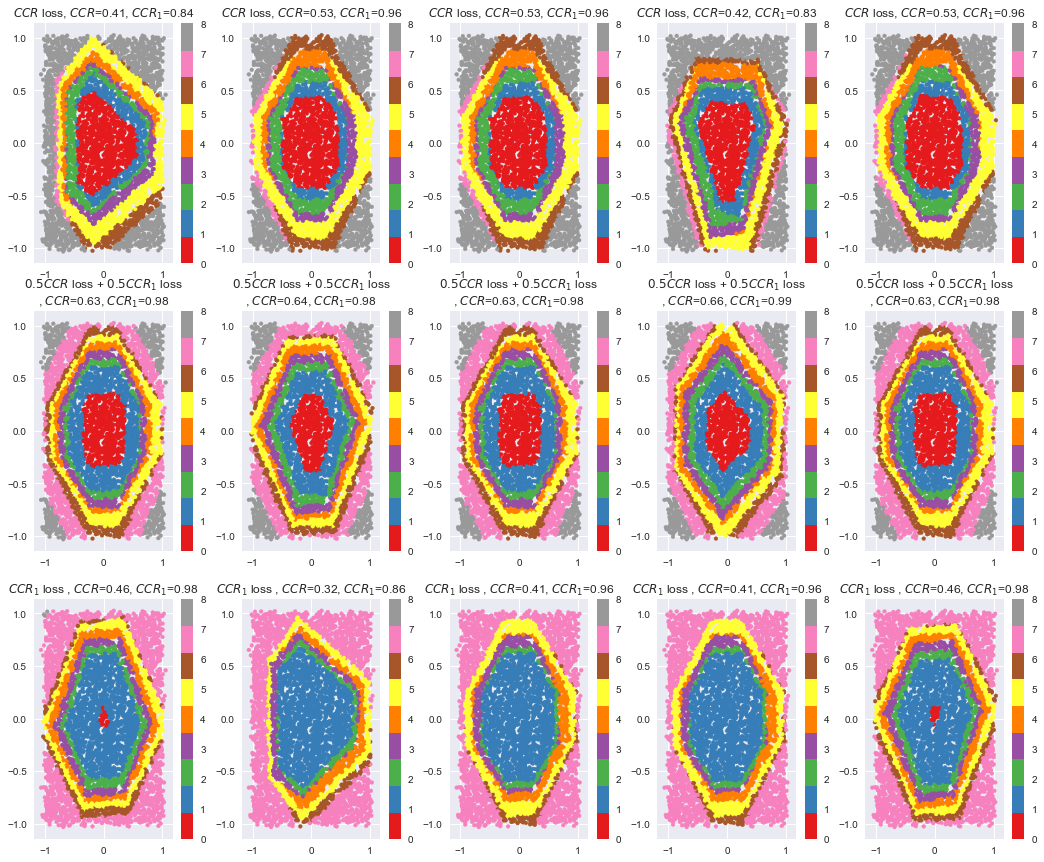

In [17]:

plt.figure(figsize=(18,15))

for k in range(5):
    plt.subplot(3,5,k+1)
    pred_tr = validate('./saved_models/test_circular' + '/' + last_dirs[k])
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    #plt.scatter(fvec_train[:, 0], fvec_train[:, 1], c=label_train,vmin=-1, vmax=num_classes)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    plt.title('$CCR$ loss' + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)))
    
for k in range(5):
    plt.subplot(3,5,k+6)
    pred_tr = validate('./saved_models/test_circular' + '/' + last_dirs[50+k])
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    #plt.scatter(fvec_train[:, 0], fvec_train[:, 1], c=label_train,vmin=-1, vmax=num_classes)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    plt.title('$0.5CCR$ loss + $0.5CCR_1$ loss \n' + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)))
    
for k in range(5):
    plt.subplot(3,5,k+11)
    pred_tr = validate('./saved_models/test_circular' + '/' + last_dirs[100+k])
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    #plt.scatter(fvec_train[:, 0], fvec_train[:, 1], c=label_train,vmin=-1, vmax=num_classes)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    plt.title('$CCR_1$ loss ' + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)))
    
plt.savefig('variance_of_results.tiff')

In [19]:
def validate_and_mean(root_dir, sub_dirs, phase='train'):
    scores_arr = np.zeros((label_train.shape[0],9))
    for sub_dir in sub_dirs:
        if use_gpu:
            model = torch.load(root_dir + '/' + sub_dir)
        else:
            model = torch.load(root_dir + '/' + sub_dir, map_location={'cuda:0': 'cpu'})
        model.train(False)
        #print(model)
        score_arr = np.zeros((1,9))
        for data in dset_loaders[phase]:
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = model(inputs).cpu().data.numpy()
                #print(outputs.shape)
            else:
                inputs, labels = Variable(inputs), Variable(labels)
                outputs = model(inputs).data.numpy()
                
            score_arr = np.append(score_arr, outputs, axis=0)
        scores_arr += score_arr[1:,:]
        
    return scores_arr
scores_tr = validate_and_mean('./saved_models/test_circular', last_dirs[:10])
pred_tr = np.argmax(scores_tr, axis=1)
print(np.mean(label_train == pred_tr))

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original

0.5576


In [35]:
model_dirs = ['./saved_models/ord/Ordinal_January24  10:16:00_last',
             './saved_models/ord/Ordinal_January24  10:20:35_last',
             './saved_models/ord/Ordinal_January24  10:24:20_last',
             './saved_models/ord/Ordinal_January24  10:28:03_last']

'''model_dirs = ['./saved_models/ord/Ordinal_January24  13:09:17_last',
             './saved_models/ord/Ordinal_January24  13:18:08_last',
             './saved_models/ord/Ordinal_January24  13:27:43_last',
             './saved_models/ord/Ordinal_January24  13:43:43_last']'''

model_dirs = ['./saved_models/ord/Ordinal_January26  00:22:14_last',
              './saved_models/ord/Ordinal_January26  00:19:20_last',
              './saved_models/ord/Ordinal_January26  00:09:08_last',
              './saved_models/ord/Ordinal_January26  00:17:53_last']
preds = []

for model_dir in model_dirs:
    preds.append(validate(model_dir))
    
print(len(preds))

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


4


/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original

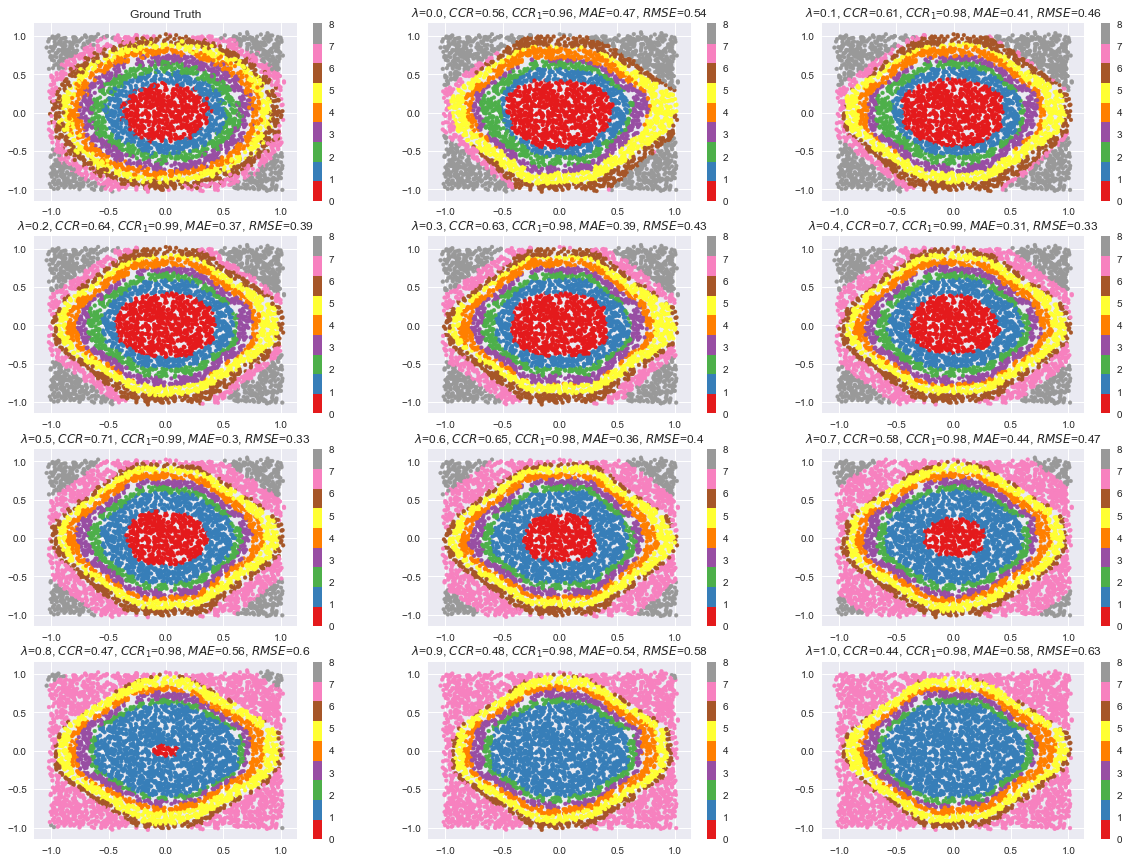

In [121]:
plt.figure(figsize=(20,15))

plt.subplot(4,3,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

metrics = np.zeros((11, 4))
for k in range(10):
    scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[k*10:(k+1)*10])
    pred_tr = np.argmax(scores_tr, axis=1)
    plt.subplot(4,3,k+2)
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    metrics[k,:] = [ccr,ccr1,mae,rmse]
    plt.title('$\lambda$=' + str(np.round(k*.1, decimals=1)) + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
              ', $MAE$=' + str(np.round(mae, decimals = 2)) +
              ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

    
#pred_tr = validate('./saved_models/ord/Ordinal_January24  10:20:35_last')
#pred_tr = validate('./saved_models/ord/Ordinal_January24  13:18:08_last')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(4,3,12)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
metrics[10,:] = [ccr,ccr1,mae,rmse]
plt.title('$\lambda$=1.0' + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ', $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))
    
plt.savefig('Circular_Data_CCR_CCR1_tradeoff.tiff')

[[  0.2216   0.5648   2.1144   9.764 ]
 [  0.1988   0.5322   2.2272  10.1556]
 [  0.2008   0.5534   2.1434   9.6494]
 [  0.201    0.5604   1.9854   8.3358]
 [  0.2042   0.5944   1.9684   8.4016]
 [  0.2046   0.6042   2.0214   9.037 ]
 [  0.1956   0.5654   2.0624   8.7972]
 [  0.2042   0.573    2.0528   8.8356]
 [  0.2044   0.5636   2.0642   8.7686]
 [  0.2086   0.6272   1.9626   8.4022]
 [  0.197    0.5798   2.0396   8.6864]]


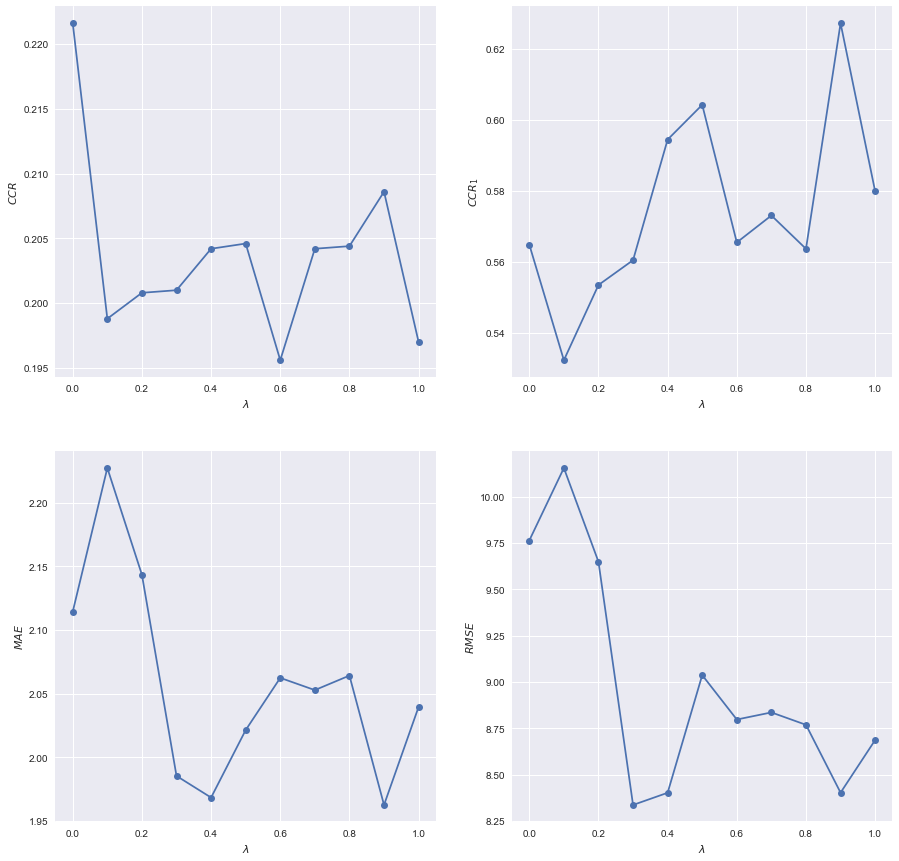

In [113]:
print(metrics)

lmbdas = [.1*k for k in range(11)]

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(lmbdas, metrics[:,0], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$CCR$')

plt.subplot(222)
plt.plot(lmbdas, metrics[:,1], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$CCR_1$')

plt.subplot(223)
plt.plot(lmbdas, metrics[:,2], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$MAE$')

plt.subplot(224)
plt.plot(lmbdas, metrics[:,3], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$RMSE$')

plt.savefig('spiral_plots_ccr1.tiff')

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original

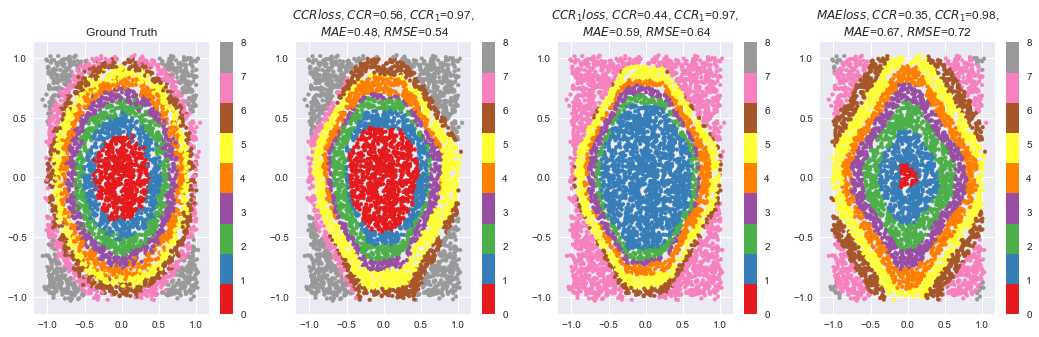

In [21]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[:10])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,2)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$CCR loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,3)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$CCR_1 loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

scores_tr = validate_and_mean('./saved_models/ord', mae_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,4)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$MAE loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n$MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

plt.savefig('spiral_extreme.tiff')

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original

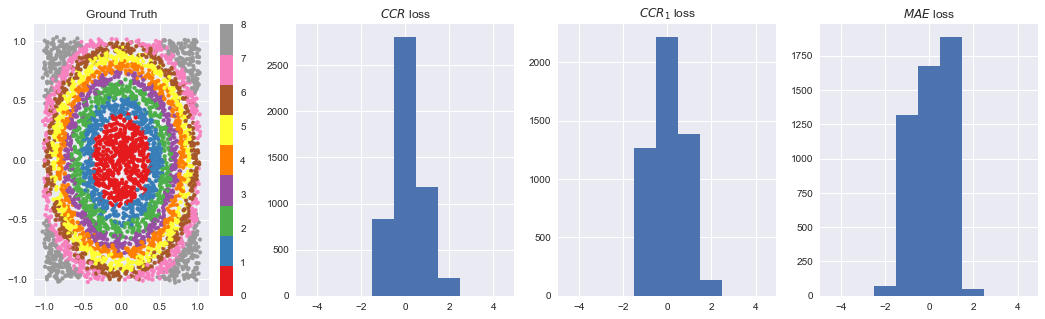

In [39]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[:10])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,2)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$CCR$ loss')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,3)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$CCR_1$ loss')

scores_tr = validate_and_mean('./saved_models/test_circular', mae_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,4)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$MAE$ loss')

plt.savefig('circular_extreme_hist.tiff')

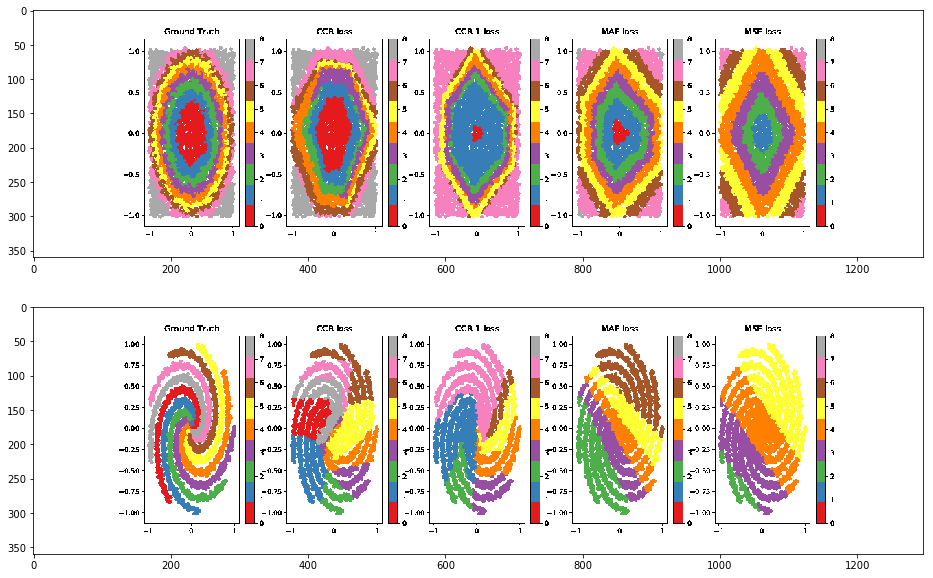

In [265]:
import matplotlib.image as mpimg

plt.figure(figsize=(18, 10))
plt.subplot(211)
img = mpimg.imread('Circular_Data_Extreme_Weights.eps')
plt.imshow(img)
plt.subplot(212)
img = mpimg.imread('Spiral_Data_Extreme_Weights.eps')
plt.imshow(img)